In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import random
import time
import math
import d2l
import os

from mxnet import autograd, np, npx, gluon, init
from mxnet.gluon import loss as gloss
from mxnet.gluon import nn
npx.set_np()

#  04. Multilayer Perceptrons
In this chapter, we will introduce your first truly deep network. The simplest deep networks are called `multilayer perceptrons`, and they consist of many layers of neurons each fully connected to those in the layer below (from which they receive input) and those above (which they, in turn, influence). When we train high-capacity models we run the risk of overfitting. Thus, we will need to provide your first rigorous introduction to the notions of `overfitting`, `underfitting`, and `capacity control`. To help you combat these problems, we will introduce regularization techniques such as `dropout` and `weight decay`. We will also discuss issues relating to numerical stability and parameter initialization that are key to successfully training deep networks. Throughout, we focus on applying models to real data, aiming to give the reader a firm grasp not just of the concepts but also of the practice of using deep networks. We punt matters relating to the computational performance, scalability and efficiency of our models to subsequent chapters.

## 4.4 Model Selection, Underfitting and Overfitting
As machine learning scientists, our goal is to discover patterns. But how can we be sure that we have truly discovered a general pattern and not simply memorized our data. For example, imagine that we wanted to hunt for patterns among genetic markers linking patients to their dementia status, (let the labels be drawn from the set $\{\mathit{dementia, mild \ cognitive \ impairment, healthy}\}$). Because each person's genes identify them uniquely (ignoring identical siblings), it is possible to memorize the entire dataset.

We do not want our model to say $\mathit{That's\ Bob! \ I\ remember\ him!\ He\ has\ dementia!}$ The reason why is simple. When we deploy the model in the future, we will encounter patients that the model has never seen before. Our predictions will only be useful if our model has truly discovered a general pattern.

To recapitulate more formally, our goal is to discover patterns that capture regularities in the underlying population from which our training set was drawn. If we are successful in this endeavor, then we could successfully assess risk even for individuals that we have never encountered before. This problem---how to discover patterns that generalize---is the fundamental problem of machine learning.

The danger is that when we train models, we access just a small sample of data. The largest public image datasets contain roughly one million images. More often, we must learn from only thousands or tens of thousands of data points. In a large hospital system, we might access hundreds of thousands of medical records. When working with finite samples, we run the risk that we might discover apparent associations that turn out not to hold up when we collect more data.

The phenomena of fitting our training data more closely than we fit the underlying distribution is called `overfitting`, and the techniques used to combat overfitting are called `regularization`. In the previous sections, you might have observed this effect while experimenting with the `Fashion-MNIST` dataset. If you altered the model structure or the hyper-parameters during the experiment, you might have noticed that with enough nodes, layers, and training epochs, the model can eventually reach perfect accuracy on the training set, even as the accuracy on test data deteriorates.

### 4.4.1 Training Error and Generalization Error
In order to discuss this phenomenon more formally, we need to differentiate between `training error` and `generalization error`:
+ training error is the error of our model as calculated on the training dataset
+ generalization error is the expectation of our model's error were we to apply it to an infinite stream of additional data points drawn from the same underlying data distribution as our original sample

Problematically, we can never calculate the generalization error exactly. That is because the stream of infinite data is an imaginary object. In practice, we must estimate the generalization error by applying our model to an independent test set constituted of a random selection of data points that were withheld from our training set.

The following three thought experiments will help illustrate this situation better. Consider a college student trying to prepare for her final exam. A diligent student will strive to practice well and test her abilities using exams from previous years. Nonetheless, doing well on past exams is no guarantee that she will excel when it matters. For instance, the student might try to prepare by rote learning the answers to the exam questions. This requires the student to memorize many things. She might even remember the answers for past exams perfectly. Another student might prepare by trying to understand the reasons for giving certain answers. In most cases, the latter student will do much better.

Likewise, consider a model that simply uses a lookup table to answer questions. If the set of allowable inputs is discrete and reasonably small, then perhaps after viewing many training examples, this approach would perform well. Still this model has no ability to do better than random guessing when faced with examples that it has never seen before. In reality the input spaces are far too large to memorize the answers corresponding to every conceivable input. For example, consider the black and white $28\times28$ images. If each pixel can take one among $256$ grayscale values, then there are $256^{784}$ possible images. That means that there are far more low-res grayscale thumbnail-sized images than there are atoms in the universe. Even if we could encounter this data, we could never afford to store the lookup table.

Last, consider the problem of trying to classify the outcomes of coin tosses (class 0: heads, class 1: tails) based on some contextual features that might be available. No matter what algorithm we come up with, the generalization error will always be $\frac{1}{2}$. However, for most algorithms, we should expect our training error to be considerably lower, depending on the luck of the draw, even if we did not have any features! Consider the dataset {0, 1, 1, 1, 0, 1}. Our feature-less algorithm would have to fall back on always predicting the majority class, which appears from our limited sample to be 1. In this case, the model that always predicts class 1 will incur an error of $\frac{1}{3}$, considerably better than our generalization error. As we increase the amount of data, the probability that the fraction of heads will deviate significantly from $\frac{1}{2}$ diminishes, and our training error would come to match the generalization error.

##### Statistical Learning Theory
Since generalization is the fundamental problem in machine learning, you might not be surprised to learn that many mathematicians and theorists have dedicated their lives to developing formal theories to describe this phenomenon. In their eponymous theorem, Glivenko and Cantelli derived the rate at which the training error converges to the generalization error. In a series of seminal papers, Vapnik and Chervonenkis extended this theory to more general classes of functions. This work laid the foundations of `Statistical Learning Theory`.

In the standard supervised learning setting, which we have addressed up until now and will stick with throughout most of this book, we assume that both the training data and the test data are drawn independently from identical distributions (commonly called the i.i.d. assumption). This means that the process that samples our data has no memory. The $2^{\mathrm{nd}}$ example drawn and the $3^{\mathrm{rd}}$ drawn are no more correlated than the $2^{\mathrm{nd}}$ and the $2$-millionth sample drawn.

Being a good machine learning scientist requires thinking critically, and already you should be poking holes in this assumption, coming up with common cases where the assumption fails. What if we train a mortality risk predictor on data collected from patients at UCSF, and apply it on patients at Massachusetts General Hospital? These distributions are simply not identical. Moreover, draws might be correlated in time. What if we are classifying the topics of Tweets. The news cycle would create temporal dependencies in the topics being discussed, violating any assumptions of independence.

Sometimes we can get away with minor violations of the i.i.d. assumption and our models will continue to work remarkably well. After all, nearly every real-world application involves at least some minor violation of the i.i.d. assumption, and yet we have useful tools for face recognition, speech recognition, language translation, etc.

Other violations are sure to cause trouble. Imagine, for example, if we try to train a face recognition system by training it exclusively on university students and then want to deploy it as a tool for monitoring geriatrics in a nursing home population. This is unlikely to work well since college students tend to look considerably different from the elderly.

In subsequent chapters and volumes, we will discuss problems arising from violations of the i.i.d. assumption. For now, even taking the i.i.d. assumption for granted, understanding generalization is a formidable problem. Moreover, elucidating the precise theoretical foundations that might explain why deep neural networks generalize as well as they do continues to vex the greatest minds in learning theory.

When we train our models, we attempt to search for a function that fits the training data as well as possible. If the function is so flexible that it can catch on to spurious patterns just as easily as to true associations, then it might perform too well without producing a model that generalizes well to unseen data. This is precisely what we want to avoid (or at least control). Many of the techniques in deep learning are heuristics and tricks aimed at guarding against overfitting.

##### Model Complexity
When we have simple models and abundant data, we expect the generalization error to resemble the training error. When we work with more complex models and fewer examples, we expect the training error to go down but the generalization gap to grow. What precisely constitutes model complexity is a complex matter. Many factors govern whether a model will generalize well. For example a model with more parameters might be considered more complex. A model whose parameters can take a wider range of values might be more complex. Often with neural networks, we think of a model that takes more training steps as more complex, and one subject to early stopping as less complex.

It can be difficult to compare the complexity among members of substantially different model classes (say a decision tree versus a neural network). For now, a simple rule of thumb is quite useful: A model that can readily explain arbitrary facts is what statisticians view as complex, whereas one that has only a limited expressive power but still manages to explain the data well is probably closer to the truth. In philosophy, this is closely related to Popper’s criterion of falsifiability of a scientific theory: a theory is good if it fits data and if there are specific tests that can be used to disprove it. This is important since all statistical estimation is post hoc, i.e., we estimate after we observe the facts, hence vulnerable to the associated fallacy. For now, we will put the philosophy aside and stick to more tangible issues.

In this section, to give you some intuition, we’ll focus on a few factors that tend to influence the generalizability of a model class:
1. The number of tunable parameters. When the number of tunable parameters, sometimes called the degrees of freedom, is large, models tend to be more susceptible to overfitting.
2. The values taken by the parameters. When weights can take a wider range of values, models can be more susceptible to overfitting.
3. The number of training examples. It’s trivially easy to overfit a dataset containing only one or two examples even if your model is simple. But overfitting a dataset with millions of examples requires an extremely flexible model.

### 4.4.2 Model Selection
In machine learning, we usually select our final model after evaluating several candidate models. This process is called model selection. Sometimes the models subject to comparison are fundamentally different in nature (say, decision trees vs linear models). At other times, we are comparing members of the same class of models that have been trained with different hyperparameter settings.

With multilayer perceptrons, for example, we may wish to compare models with different numbers of hidden layers, different numbers of hidden units, and various choices of the activation functions applied to each hidden layer. In order to determine the best among our candidate models, we will typically employ a validation set.

##### Validation Dataset
In principle we should not touch our test set until after we have chosen all our hyper-parameters. Were we to use the test data in the model selection process, there is a risk that we might overfit the test data. Then we would be in serious trouble. If we overfit our training data, there is always the evaluation on test data to keep us honest. But if we overfit the test data, how would we ever know?

Thus, we should never rely on the test data for model selection. And yet we cannot rely solely on the training data for model selection either because we cannot estimate the generalization error on the very data that we use to train the model.

The common practice to address this problem is to split our data three ways, incorporating a validation set in addition to the training and test sets.

In practical applications, the picture gets muddier. While ideally we would only touch the test data once, to assess the very best model or to compare a small number of models to each other, real-world test data is seldom discarded after just one use. We can seldom afford a new test set for each round of experiments.

The result is a murky practice where the boundaries between validation and test data are worryingly ambiguous. Unless explicitly stated otherwise, in the experiments in this book we are really working with what should rightly be called training data and validation data, with no true test sets. Therefore, the accuracy reported in each experiment is really the validation accuracy and not a true test set accuracy. The good news is that we do not need too much data in the validation set. The uncertainty in our estimates can be shown to be of the order of $\mathcal{O}(n^{-\frac{1}{2}})$.

##### $K$-Fold Cross-Validation
When training data is scarce, we might not even be able to afford to hold out enough data to constitute a proper validation set. One popular solution to this problem is to employ $K$-fold cross-validation. Here, the original training data is split into $K$ non-overlapping subsets. Then model training and validation are executed $K$ times, each time training on $K-1$ subsets and validating on a different subset (the one not used for training in that round). Finally, the training and validation error rates are estimated by averaging over the results from the $K$ experiments.

### 4.4.3 Underfitting or Overfitting?
When we compare the training and validation errors, we want to be mindful of two common situations: First, we want to watch out for cases when our training error and validation error are both substantial but there is a little gap between them. If the model is unable to reduce the training error, that could mean that our model is too simple (i.e., insufficiently expressive) to capture the pattern that we are trying to model. Moreover, since the generalization gap between our training and validation errors is small, we have reason to believe that we could get away with a more complex model. This phenomenon is known as `underfitting`.

On the other hand, as we discussed above, we want to watch out for the cases when our training error is significantly lower than our validation error, indicating severe `overfitting`. Note that overfitting is not always a bad thing. With deep learning especially, it is well known that the best predictive models often perform far better on training data than on holdout data. Ultimately, we usually care more about the validation error than about the gap between the training and validation errors.

Whether we overfit or underfit can depend both on the complexity of our model and the size of the available training datasets, two topics that we discuss below.

##### Model Complexity
To illustrate some classical intuition about overfitting and model complexity, we give an example using polynomials. Given training data consisting of a single feature $x$ and a corresponding real-valued label $y$, we try to find the polynomial of degree $d$
$$\hat{y}= \sum_{i=0}^d x^i w_i$$

to estimate the labels $y$. This is just a linear regression problem where our features are given by the powers of $x$, the model's weights are given by $w_i$, and the bias is given by $w_0$ since $x^0 = 1$ for all $x$. Since this is just a linear regression problem, we can use the squared error as our loss function.

A higher-order polynomial function is more complex than a lower order polynomial function, since the higher-order polynomial has more parameters and the model function’s selection range is wider. Fixing the training dataset, higher-order polynomial functions should always achieve lower (at worst, equal) training error relative to lower degree polynomials. In fact, whenever the data points each have a distinct value of $x$, a polynomial function with degree equal to the number of data points can fit the training set perfectly. We visualize the relationship between polynomial degree and under- vs over-fitting in `Fig. 4.4.1`.

<img src="images/04_03.png" style="width:400px;"/>

##### Dataset Size
The other big consideration to bear in mind is the dataset size. Fixing our model, the fewer samples we have in the training dataset, the more likely (and more severely) we are to encounter overfitting. As we increase the amount of training data, the generalization error typically decreases. Moreover, in general, more data never hurts. For a fixed task and data distribution, there is typically a relationship between model complexity and dataset size. Given more data, we might profitably attempt to fit a more complex model. Absent sufficient data, simpler models may be difficult to beat. For many tasks, deep learning only outperforms linear models when many thousands of training examples are available. In part, the current success of deep learning owes to the current abundance of massive datasets due to Internet companies, cheap storage, connected devices, and the broad digitization of the economy.

### 4.4.4 Polynomial Regression
We can now explore these concepts interactively by fitting polynomials to data. 

##### Generating the Dataset
First we need data. Given $x$, we will use the following cubic polynomial to generate the labels on training and test data:
$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where } \epsilon \sim \mathcal{N}(0, 0.1).$$

The noise term $\epsilon$ obeys a normal distribution with a mean of 0 and a standard deviation of 0.1. We will synthesize 100 samples each for the training set and test set.

In [2]:
maxdegree = 20  # Maximum degree of the polynomial
n_train, n_test = 100, 100  # Training and test dataset sizes
true_w = np.zeros(maxdegree)  # Allocate lots of empty space
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
features = np.random.shuffle(features)
poly_features = np.power(features, np.arange(maxdegree).reshape(1, -1))
poly_features = poly_features / (npx.gamma(np.arange(maxdegree) + 1).reshape(1, -1))
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

For optimization, we typically want to avoid very large values of gradients, losses, etc. This is why the monomials stored in `poly_features` are rescaled from $x^i$ to $\frac{1}{i!} x^i$. It allows us to avoid very large values for large exponents $i$. Factorials are implemented in `Gluon` using the `Gamma function`, where $n! = \Gamma(n+1)$.

Take a look at the first 2 samples from the generated dataset. The value 1 is technically a feature, namely the constant feature corresponding to the bias.

In [3]:
features[:2], poly_features[:2], labels[:2]

(array([[-0.03716067],
        [-1.1468065 ]]),
 array([[ 1.00000000e+00, -3.71606685e-02,  6.90457586e-04,
         -8.55262169e-06,  7.94552903e-08, -5.90522298e-10,
          3.65736781e-12, -1.94157468e-14,  9.01877669e-17,
         -3.72381952e-19,  1.38379632e-21, -4.67479919e-24,
          1.44765544e-26, -4.13814185e-29,  1.09840096e-31,
         -2.72115417e-34,  6.31999508e-37, -1.38150092e-39,
          2.85164237e-42, -5.60519386e-45],
        [ 1.00000000e+00, -1.14680648e+00,  6.57582462e-01,
         -2.51373291e-01,  7.20691308e-02, -1.65298693e-02,
          3.15942708e-03, -5.17607376e-04,  7.41994299e-05,
         -9.45470947e-06,  1.08427230e-06, -1.13040933e-07,
          1.08030065e-08, -9.52996682e-10,  7.80644993e-11,
         -5.96832479e-12,  4.27782104e-13, -2.88578399e-14,
          1.83857543e-15, -1.10973161e-16]]),
 array([ 5.1432443 , -0.06415092]))

##### Training and Testing Model
Let us first implement a function to evaluate the loss on a given data.

In [4]:
def evaluate_loss(net, data_iter, loss):  #@save
    """Evaluate the loss of a model on the given dataset."""
    metric = d2l.Accumulator(2)  # sum_loss, num_examples
    for X, y in data_iter:
        metric.add(loss(net(X), y).sum(), y.size)
    return metric[0] / metric[1]

Now define the training function.

In [5]:
def train(train_features, test_features, train_labels, test_labels, num_epochs=1000):
    loss = gluon.loss.L2Loss()
    net = nn.Sequential()
    # Switch off the bias since we already catered for it in the polynomial features
    net.add(nn.Dense(1, use_bias=False))
    net.initialize()
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    test_iter = d2l.load_array((test_features, test_labels), batch_size, is_train=False)
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.01})
    animator = d2l.Animator(xlabel='epoch', 
                            ylabel='loss', 
                            yscale='log',
                            xlim=[1, num_epochs], 
                            ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(1, num_epochs+1):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch % 50 == 0:
            animator.add(epoch, (evaluate_loss(net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data().asnumpy())

##### Third-Order Polynomial Function Fitting (Normal)
We will begin by first using a third-order polynomial function with the same order as the data generation function. The results show that this model’s training error rate when using the testing dataset is low. The trained model parameters are also close to the true values $w = [5, 1.2, -3.4, 5.6]$.

weight: [[ 5.01586    1.1958243 -3.4174228  5.619878 ]]


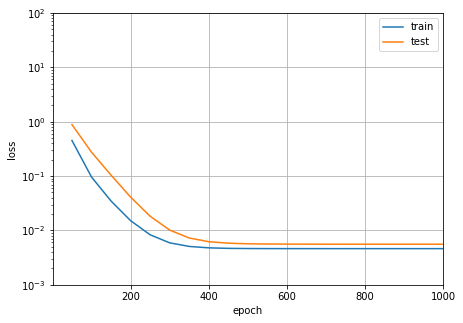

In [6]:
# Pick the first four dimensions, i.e., 1, x, x^2, x^3 from the polynomial
# features
train(poly_features[:n_train, 0:4], poly_features[n_train:, 0:4], labels[:n_train], labels[n_train:])

##### Linear Function Fitting (Underfitting)
Let’s take another look at linear function fitting. After the decline in the early epoch, it becomes difficult to further decrease this model’s training error rate. After the last epoch iteration has been completed, the training error rate is still high. When used to fit non-linear patterns (like the third-order polynomial function here) linear models are liable to underfit.

weight: [[ 5.260686  4.02781  -3.996469]]


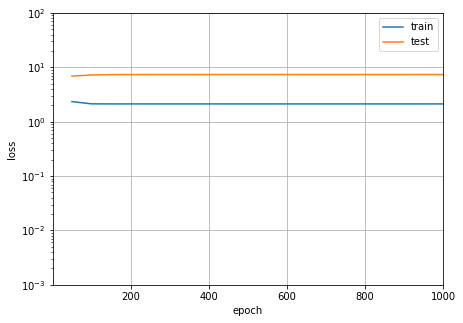

In [7]:
# Pick the first four dimensions, i.e., 1, x from the polynomial features
train(poly_features[:n_train, 0:3], poly_features[n_train:, 0:3], labels[:n_train], labels[n_train:])

##### Insufficient Training (Overfitting)
Now let us try to train the model using a polynomial of too high degree. Here, there is insufficient data to learn that the higher-degree coefficients should have values close to zero. As a result, our overly-complex model is far too susceptible to being influenced by noise in the training data. Of course, our training error will now be low (even lower than if we had the right model!) but our test error will be high.

Try out different model complexities (n_degree) and training set sizes (n_subset) to gain some intuition of what is happening.

weight: [[ 4.948221    1.3322161  -3.20923     5.0429883  -0.42180654  1.3481839
   0.07487395  0.19202796 -0.01925157  0.01775409 -0.0509589  -0.02382538
  -0.01497422 -0.04940007  0.06389722 -0.04761841 -0.04380195 -0.05188226
   0.05655775  0.01104914]]


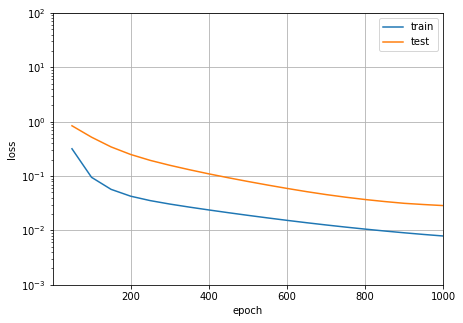

In [8]:
n_subset = 100  # Subset of data to train on
n_degree = 20  # Degree of polynomials
train(poly_features[1:n_subset, 0:n_degree], 
      poly_features[n_train:, 0:n_degree], 
      labels[1:n_subset],
      labels[n_train:])

In later chapters, we will continue to discuss overfitting problems and methods for dealing with them, such as weight decay and dropout.

##### Summary
+ Since the generalization error rate cannot be estimated based on the training error rate, simply minimizing the training error rate will not necessarily mean a reduction in the generalization error rate. Machine learning models need to be careful to safeguard against overfitting such as to minimize the generalization error.
+ A validation set can be used for model selection (provided that it is not used too liberally).
+ Underfitting means that the model is not able to reduce the training error rate, while overfitting is a result of the model training error rate being much lower than the testing dataset rate.
+ We should choose an appropriately complex model and avoid using insufficient training samples.

##### Exercises
1. Can you solve the polynomial regression problem exactly? Hint: use linear algebra.
2. Model selection for polynomials
    + Plot the training error vs. model complexity (degree of the polynomial). What do you observe?
    + Plot the test error in this case.
    + Generate the same graph as a function of the amount of data?
3. What happens if you drop the normalization of the polynomial features $x^i$ by $1/i!$. Can you fix this in some other way?
4. What degree of polynomial do you need to reduce the training error to 0?
5. Can you ever expect to see 0 generalization error?


## 4.5 Weight Decay
Now that we have characterized the problem of overfitting, we can introduce some standard techniques for regularizing models. Recall that we can always mitigate overfitting by going out and collecting more training data. That can be costly, time consuming, or entirely out of our control, making it impossible in the short run. For now, we can assume that we already have as much high-quality data as our resources permit and focus on regularization techniques.

Recall that in our polynomial curve-fitting example (`Section 4.4`) we could limit our model's capacity simply by tweaking the degree of the fitted polynomial. Indeed, limiting the number of features is a popular technique to avoid overfitting. However, simply tossing aside features can be too blunt an instrument for the job. Sticking with the polynomial curve-fitting example, consider what might happen with high-dimensional inputs. The natural extensions of polynomials to multivariate data are called `monomials`, which are simply products of powers of variables. The degree of a monomial is the sum of the powers. For example, $x_1^2 x_2$, and $x_3 x_5^2$ are both monomials of degree $3$.

Note that the number of terms with degree $d$ blows up rapidly as $d$ grows larger. Given $k$ variables, the number of monomials of degree $d$ is ${k - 1 + d} \choose {k - 1}$. Even small changes in degree, say from $2$ to $3$, dramatically increase the complexity of our model. Thus we often need a more fine-grained tool for adjusting function complexity.

### 4.5.1 Squared Norm Regularization
Weight decay (commonly called $L2$ regularization), might be the most widely-used technique for regularizing parametric machine learning models. The technique is motivated by the basic intuition that among all functions $f$, the function $f = 0$ (assigning the value $0$ to all inputs) is in some sense the simplest, and that we can measure the complexity of a function by its distance from zero. But how precisely should we measure the distance between a function and zero? There is no single right answer. In fact, entire branches of mathematics, including parts of functional analysis and the theory of Banach spaces, are devoted to answering this issue.

One simple interpretation might be to measure the complexity of a linear function $f(\mathbf{x}) = \mathbf{w}^\top \mathbf{x}$ by some norm of its weight vector, e.g., $\Vert\mathbf{w}\Vert^2$. The most common method for ensuring a small weight vector is to add its norm as a penalty term to the problem of minimizing the loss. Thus we replace our original objective, minimize the prediction loss on the training labels, with new objective, minimize the sum of the prediction loss and the penalty term. Now, if our weight vector grows too large, our learning algorithm might focus on minimizing the weight norm $\Vert\mathbf{w}\Vert^2$ versus minimizing the training error. That is exactly what we want. To illustrate things in code, let us revive our previous example from `Section 3.1` for linear regression. There, our loss was given by
$$l(\mathbf{w}, b) = \frac{1}{n}\sum_{i=1}^n \frac{1}{2}\left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)^2.$$

Recall that $\mathbf{x}^{(i)}$ are the observations, $y^{(i)}$ are labels, and $(\mathbf{w}, b)$ are the weight and bias parameters respectively. To penalize the size of the weight vector, we must somehow add $\Vert\mathbf{w}\Vert^2$ to the loss function, but how should the model trade off the standard loss for this new additive penalty? In practice, we characterize this tradeoff via the regularization constant $\lambda > 0$, a non-negative hyperparameter that we fit using validation data:
$$l(\mathbf{w}, b) + \frac{\lambda}{2} |\mathbf{w}|^2.$$

For $\lambda = 0$, we recover our original loss function. For $\lambda > 0$, we restrict the size of $\Vert\mathbf{w}\Vert$. The astute reader might wonder why we work with the squared norm and not the standard norm (i.e., the Euclidean distance). We do this for computational convenience. By squaring the $L2$ norm, we remove the square root, leaving the sum of squares of each component of the weight vector. This makes the derivative of the penalty easy to compute (the sum of derivatives equals the derivative of the sum).

Moreover, you might ask why we work with the $L2$ norm in the first place and not, say, the $L1$ norm.

In fact, other choices are valid and popular throughout statistics. While $L2$-regularized linear models constitute the classic `ridge regression` algorithm, $L1$-regularized linear regression is a similarly fundamental model in statistics (popularly known as `lasso regression`).

More generally, the $\ell_2$ is just one among an infinite class of norms call p-norms, many of which you might encounter in the future. In general, for some number $p$, the $\ell_p$ norm is defined as
$$\Vert\mathbf{w}\Vert_p^p := \displaystyle\sum_{i=1}^d |w_i|^p.$$

One reason to work with the $L2$ norm is that it places and outsize penalty on large components of the weight vector. This biases our learning algorithm towards models that distribute weight evenly across a larger number of features. In practice, this might make them more robust to measurement error in a single variable. By contrast, $L1$ penalties lead to models that concentrate weight on a small set of features, which may be desirable for other reasons.

> **翻译**
> 
> 使用$L2$范数的原因之一是，它在权重向量的较大部分上放置了较大的惩罚。这使我们的学习算法偏向于将权重均匀分布在大量特征上的模型。在实践中，这可能使它们对单个变量中的测量误差更加鲁棒。相比之下，$L1$的罚款导致模型将重量集中在少数特征上，这可能是出于其他原因所希望的。

The stochastic gradient descent updates for $L2$-regularized regression follow:
$$ \begin{aligned} \mathbf{w} & \leftarrow \left(1- \eta\lambda \right) \mathbf{w} - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \mathbf{x}^{(i)} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right), \end{aligned} $$

As before, we update $\mathbf{w}$ based on the amount by which our estimate differs from the observation. However, we also shrink the size of $\mathbf{w}$ towards $0$. That is why the method is sometimes called "weight decay": given the penalty term alone, our optimization algorithm decays the weight at each step of training. In contrast to feature selection, weight decay offers us a continuous mechanism for adjusting the complexity of $f$. Small values of $\lambda$ correspond to unconstrained $\mathbf{w}$, whereas large values of $\lambda$ constrain $\mathbf{w}$ considerably. Whether we include a corresponding bias penalty $b^2$ can vary across implementations, and may vary across layers of a neural network. Often, we do not regularize the bias term of a network's output layer.

### 4.5.2 High-Dimensional Linear Regression
We can illustrate the benefits of weight decay over feature selection through a simple synthetic example. First, we generate some data as before
$$y = 0.05 + \sum_{i = 1}^d 0.01 x_i + \epsilon \text{ where } \epsilon \sim \mathcal{N}(0, 0.01).$$

choosing our label to be a linear function of our inputs, corrupted by Gaussian noise with zero mean and variance 0.01. To make the effects of overfitting pronounced, we can increase the dimensionality of our problem to $d = 200$ and work with a small training set containing only 20 examples.

In [9]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = np.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

### 4.5.3 Implementation from Scratch
Next, we will implement weight decay from scratch, simply by adding the squared $\ell_2$ penalty to the original target function.

##### Initializing Model Parameters
First, we will define a function to randomly initialize our model parameters and allocate memory for the gradients we will calculate.

In [10]:
def init_params():
    w = np.random.normal(scale=1, size=(num_inputs, 1))
    b = np.zeros(1)
    w.attach_grad()
    b.attach_grad()
    return [w, b]

##### Defining $\ell_2$ Norm Penalty
Perhaps the most convenient way to implement this penalty is to square all terms in place and sum them up. We divide by $2$ by convention (when we take the derivative of a quadratic function, the $2$ and $1/2$ cancel out, ensuring that the expression for the update looks nice and simple).

In [11]:
def l2_penalty(w):
    return (w**2).sum() / 2

##### Defining the Train and Test Functions
The following code fits a model on the training set and evaluates it on the test set. The linear network and the squared loss have not changed since the previous chapter, so we will just import them via d2l.linreg and d2l.squared_loss. The only change here is that our loss now includes the penalty term.

In [12]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], legend=['train', 'test'])
    for epoch in range(1, num_epochs + 1):
        for X, y in train_iter:
            with autograd.record():
                # The L2 norm penalty term has been added, and broadcasting
                # makes l2_penalty(w) a vector whose length is batch_size
                l = loss(net(X), y) + lambd * l2_penalty(w)
            l.backward()
            d2l.sgd([w, b], lr, batch_size)
        if epoch % 5 == 0:
            animator.add(epoch, (d2l.evaluate_loss(net, train_iter, loss),
                                 d2l.evaluate_loss(net, test_iter, loss)))
    print('l1 norm of w:', np.abs(w).sum())

##### Training without Regularization
We now run this code with `lambd = 0`, disabling weight decay. Note that we overfit badly, decreasing the training error but not the test error---a textook case of overfitting.

l1 norm of w: 139.60918


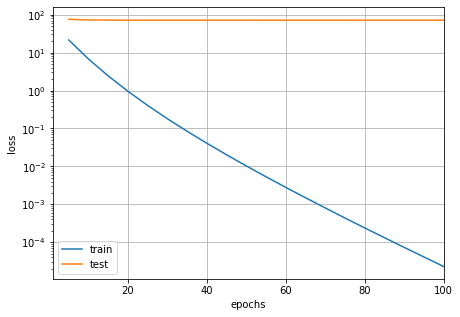

In [13]:
train(lambd=0)

##### Using Weight Decay
Below, we run with substantial weight decay. Note that the training error increases but the test error decreases. This is precisely the effect we expect from regularization. As an exercise, you might want to check that the $\ell_2$ norm of the weights $\mathbf{w}$ has actually decreased.

l1 norm of w: 4.394982


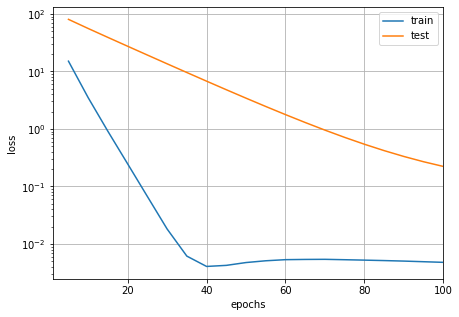

In [14]:
train(lambd=3)

### 4.5.4 Concise Implementation
Because weight decay is ubiquitous in neural network optimization, `Gluon` makes it especially convenient, integrating weight decay into the optimization algorithm itself for easy use in combination with any loss function. Moreover, this integration serves a computational benefit, allowing implementation tricks to add weight decay to the algorithm, without any additional computational overhead. Since the weight decay portion of the update depends only on the current value of each parameter, and the optimizer must touch each parameter once anyway.

In the following code, we specify the weight decay hyperparameter directly through `wd` when instantiating our `Trainer`. By default, `Gluon` decays both weights and biases simultaneously. Note that the hyperparameter `wd` will be multiplied by `wd_mult` when updating model parameters. Thus, if we set `wd_mult` to $0$, the bias parameter $b$ will not decay. 

In [15]:
def train_gluon(wd):
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize(init.Normal(sigma=1))
    loss = gluon.loss.L2Loss()
    num_epochs, lr = 100, 0.003
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr, 'wd': wd})
    # The bias parameter has not decayed. Bias names generally end with "bias"
    net.collect_params('.*bias').setattr('wd_mult', 0)
    animator = d2l.Animator(xlabel='epochs', 
                            ylabel='loss', 
                            yscale='log',
                            xlim=[1, num_epochs], 
                            legend=['train', 'test'])
    for epoch in range(1, num_epochs+1):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        if epoch % 5 == 0:
            animator.add(epoch, (d2l.evaluate_loss(net, train_iter, loss),
                                 d2l.evaluate_loss(net, test_iter, loss)))
    print('L1 norm of w:', np.abs(net[0].weight.data()).sum())

The plots look identical to those when we implemented weight decay from scratch. However, they run appreciably faster and are easier to implement, a benefit that will become more pronounced for large problems.

L1 norm of w: 143.568


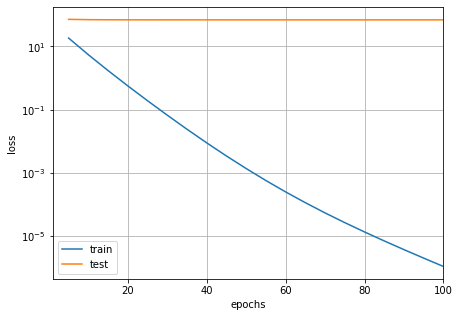

In [16]:
train_gluon(0)

L1 norm of w: 3.566406


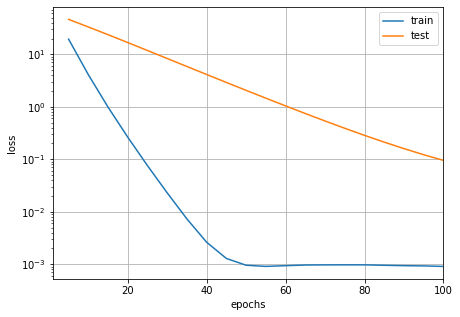

In [17]:
train_gluon(3)

L1 norm of w: 0.2461776


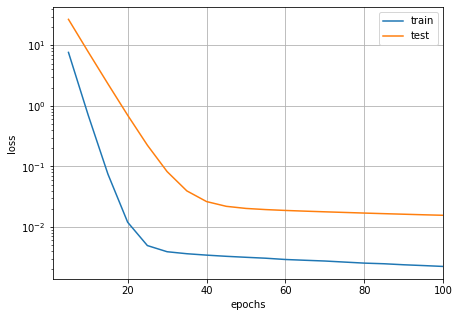

In [18]:
train_gluon(10)

So far, we only touched upon one notion of what constitutes a simple linear function. Moreover, what constitutes a simple nonlinear function can be an even more complex question. For instance, Reproducing Kernel Hilbert Spaces (RKHS) allows one to apply tools introduced for linear functions in a nonlinear context. Unfortunately, RKHS-based algorithms tend to scale purely to large, high-dimensional data. In this book we will default to the simple heuristic of applying weight decay on all layers of a deep network.

##### Summary
+ Regularization is a common method for dealing with overfitting. It adds a penalty term to the loss function on the training set to reduce the complexity of the learned model.
+ One particular choice for keeping the model simple is weight decay using an $\ell_2$ penalty. This leads to weight decay in the update steps of the learning algorithm.
+ Gluon provides automatic weight decay functionality in the optimizer by setting the hyperparameter wd.
+ You can have different optimizers within the same training loop, e.g., for different sets of parameters.

##### Exercises
1. Experiment with the value of $\lambda$ in the estimation problem in this page. Plot training and test accuracy as a function of $\lambda$. What do you observe?
2. Use a validation set to find the optimal value of $\lambda$. Is it really the optimal value? Does this matter?
3. What would the update equations look like if instead of $\Vert\mathbf{w}\Vert^2$ we used $\sum_i |w_i|$ as our penalty of choice (this is called $\ell_1$ regularization).
4. We know that $\Vert\mathbf{w}\Vert^2 = \mathbf{w}^\top \mathbf{w}$. Can you find a similar equation for matrices (mathematicians call this the Frobenius norm)?
5. Review the relationship between training error and generalization error. In addition to weight decay, increased training, and the use of a model of suitable complexity, what other ways can you think of to deal with overfitting?
6. In Bayesian statistics we use the product of prior and likelihood to arrive at a posterior via $P(w \mid x) \propto P(x \mid w) P(w)$. How can you identify $P(w)$ with regularization?


## 4.6 Dropout
In `Section 4.5`, we introduced the classical approach to regularizing statistical models by penalizing the $\ell_2$ norm of the weights. In probabilistic terms, we could justify this technique by arguing that we have assumed a prior belief that weights take values from a Gaussian distribution with mean $0$. More intuitively, we might argue that we encouraged the model to spread out its weights among many features rather than depending too much on a small number of potentially spurious associations.

### 4.6.1 Overfitting Revisited
Faced with more features than examples, linear models tend to overfit. But given more examples than features, we can generally count on linear models not to overfit. Unfortunately, the reliability with which linear models generalize comes at a cost: Naively applied, linear models do not take into account interactions among features. For every feature, a linear model must assign either a positive or a negative weight, ignoring context.

In traditional texts, this fundamental tension between generalizability and flexibility is described as the `bias-variance tradeoff`. Linear models have high bias (they can only represent a small class of functions), but low variance (they give similar results across different random samples of the data).

Deep neural networks inhabit the opposite end of the bias-variance spectrum. Unlike linear models, neural networks are not confined to looking at each feature individually. They can learn interactions among groups of features. For example, they might infer that “Nigeria” and “Western Union” appearing together in an email indicates spam but that separately they do not.

Even when we have far more examples than features, deep neural networks are capable of overfitting. In 2017, a group of researchers demonstrated the extreme flexibility of neural networks by training deep nets on randomly-labeled images. Despite the absence of any true pattern linking the inputs to the outputs, they found that the neural network optimized by SGD could label every image in the training set perfectly.

> 即便如此，当我们的样例比特征多得多，深度神经网络仍具有过度拟合的能力。2017年，一组研究人员通过在随机标记的图像上训练深层网络来展示神经网络的极端灵活性。尽管没有将输入链接到输出的任何真实模式，但他们发现SGD优化的神经网络可以完美标记训练集中的每个图像。

Consider what this means. If the labels are assigned uniformly at random and there are 10 classes, then no classifier can do better than 10% accuracy on holdout data. The generalization gap here is a whopping 90%. If our models are so expressive that they can overfit this badly, then when should we expect them not to overfit? The mathematical foundations for the puzzling generalization properties of deep networks remain open research questions, and we encourage the theoretically-oriented reader to dig deeper into the topic. For now, we turn to the more terrestrial investigation of practical tools that tend (empirically) to improve the generalization of deep nets.

> 考虑一下这意味着什么。如果标签是随机随机分配的，并且有10个类别，则分类器对保持数据的准确度不能超过10％。这里的泛化差距高达90％。如果我们的模型表现力如此之强以至于它们可能严重拟合过度，那么我们何时应该期望它们不会过度拟合呢？深度网络的令人困惑的泛化特性的数学基础仍然是开放的研究问题，我们鼓励以理论为导向的读者更深入地研究该主题。就目前而言，我们将转向对实用工具进行更深入的研究，这些实用工具倾向于（凭经验）改善深网的泛化性。

### 4.6.2 Robustness through Perturbations
> 通过扰动实现鲁棒性

Let us think briefly about what we expect from a good predictive model. We want it to peform well on unseen data. Classical generalization theory suggests that to close the gap between train and test performance, we should aim for a simple model. Simplicity can come in the form of a small number of dimensions. We explored this when discussing the monomial basis functions of linear models `Section 4.4`. Additionally, as we saw when discussing weight decay ($\ell_2$ regularization) `Section 4.5`, the (inverse) norm of the parameters represents another useful measure of simplicity. Another useful notion of simplicity is smoothness, i.e., that the function should not be sensitive to small changes to its inputs. For instance, when we classify images, we would expect that adding some random noise to the pixels should be mostly harmless.

In 1995, Christopher Bishop formalized this idea when he proved that training with input noise is equivalent to Tikhonov regularization (`Bishop.1995`). This work drew a clear mathematical connection between the requirement that a function be smooth (and thus simple), and the requirement that it be resilient to perturbations in the input.

Then, in 2014, Srivastava et al. (`Srivastava.Hinton.Krizhevsky.ea.2014`) developed a clever idea for how to apply Bishop's idea to the internal layers of the network, too. Namely, they proposed to inject noise into each layer of the network before calculating the subsequent layer during training. They realized that when training a deep network with many layers, injecting noise enforces smoothness just on the input-output mapping.

Their idea, called `dropout`, involves injecting noise while computing each internal layer during forward propagation, and it has become a standard technique for training neural networks. The method is called `dropout` because we literally drop out some neurons during training. Throughout training, on each iteration, standard dropout consists of zeroing out some fraction (typically 50%) of the nodes in each layer before calculating the subsequent layer.

To be clear, we are imposing our own narrative with the link to Bishop. The original paper on dropout offers intuition through a surprising analogy to sexual reproduction. The authors argue that neural network overfitting is characterized by a state in which each layer relies on a specifc pattern of activations in the previous layer, calling this condition `co-adaptation`. Dropout, they claim, breaks up co-adaptation just as sexual reproduction is argued to break up co-adapted genes.

The key challenge then is how to inject this noise. One idea is to inject the noise in an unbiased manner so that the expected value of each layer---while fixing the others---equals to the value it would have taken absent noise.

In Bishop's work, he added Gaussian noise to the inputs to a linear model: At each training iteration, he added noise sampled from a distribution with mean zero $\epsilon \sim \mathcal{N}(0,\sigma^2)$ to the input $\mathbf{x}$, yielding a perturbed point $\mathbf{x}' = \mathbf{x} + \epsilon$. In expectation, $E[\mathbf{x}'] = \mathbf{x}$.

In standard dropout regularization, one debiases each layer by normalizing by the fraction of nodes that were retained (not dropped out). In other words, dropout with dropout probability $p$ is applied as follows:
$$ \begin{aligned} h' = \begin{cases} 0 & \text{ with probability } p \\ \frac{h}{1-p} & \text{ otherwise} \end{cases} \end{aligned} $$

By design, the expectation remains unchanged, i.e., $E[h'] = h$. Intermediate activations $h$ are replaced by a random variable $h'$ with matching expectation.

### 4.6.3 Dropout in Practice
Recall the multilayer perceptron (`Section 4.1`) with a hidden layer and 5 hidden units. Its architecture is given by
$$ \begin{aligned} \mathbf{h} & = \sigma(\mathbf{W}_1 \mathbf{x} + \mathbf{b}_1), \\ \mathbf{o} & = \mathbf{W}_2 \mathbf{h} + \mathbf{b}_2, \\ \hat{\mathbf{y}} & = \mathrm{softmax}(\mathbf{o}). \end{aligned} $$

When we apply dropout to a hidden layer, zeroing out each hidden unit with probability $p$, the result can be viewed as a network containing only a subset of the original neurons. In `Fig. 4.6.1`, $h_2$ and $h_5$ are removed. Consequently, the calculation of $y$ no longer depends on $h_2$ and $h_5$ and their respective gradient also vanishes when performing backprop. In this way, the calculation of the output layer cannot be overly dependent on any one element of $h_1, \ldots, h_5$.

<img src="images/04_04.png" style="width:500px;"/>

Typically, we disable dropout at test time. Given a trained model and a new example, we do not drop out any nodes (and thus do not need to normalize). However, there are some exceptions: some researchers use dropout at test time as a heuristic for estimating the uncertainty of neural network predictions: if the predictions agree across many different dropout masks, then we might say that the network is more confident. For now we will put off uncertainty estimation for subsequent chapters and volumes.

### 4.6.4 Implementation from Scratch
To implement the dropout function for a single layer, we must draw as many samples from a Bernoulli (binary) random variable as our layer has dimensions, where the random variable takes value $1$ (keep) with probability $1-p$ and $0$ (drop) with probability $p$. One easy way to implement this is to first draw samples from the uniform distribution $U[0, 1]$. Then we can keep those nodes for which the corresponding sample is greater than $p$, dropping the rest.

In the following code, we implement a `dropout_layer` function that drops out the elements in the tensor input X with probability dropout, rescaling the remainder as described above (dividing the survivors by `1.0-dropout`).

In [19]:
def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    # In this case, all elements are dropped out
    if dropout == 1:
        return np.zeros_like(X)
    # In this case, all elements are kept
    if dropout == 0:
        return X
    mask = np.random.uniform(0, 1, X.shape) > dropout
    return mask.astype(np.float32) * X / (1.0-dropout)

We can test out the `dropout_layer` function on a few examples. In the following lines of code, we pass our input $X$ through the dropout operation, with probabilities 0, 0.5, and 1, respectively.

In [20]:
X = np.arange(16).reshape(2, 8)
print(dropout_layer(X, 0))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1))

[[ 0.  1.  2.  3.  4.  5.  6.  7.]
 [ 8.  9. 10. 11. 12. 13. 14. 15.]]
[[ 0.  0.  4.  6.  0. 10. 12. 14.]
 [ 0. 18. 20. 22. 24.  0. 28.  0.]]
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


##### Defining Model Parameters
Again, we work with the `Fashion-MNIST` dataset introduced in `Section 3.6`. We define a multilayer perceptron with two hidden layers containing 256 outputs each.

In [21]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

W1 = np.random.normal(scale=0.01, size=(num_inputs, num_hiddens1))
b1 = np.zeros(num_hiddens1)
W2 = np.random.normal(scale=0.01, size=(num_hiddens1, num_hiddens2))
b2 = np.zeros(num_hiddens2)
W3 = np.random.normal(scale=0.01, size=(num_hiddens2, num_outputs))
b3 = np.zeros(num_outputs)

params = [W1, b1, W2, b2, W3, b3]
for param in params:
    param.attach_grad()

##### Defining the Model
The model below applies dropout to the output of each hidden layer (following the activation function). We can set dropout probabilities for each layer separately. A common trend is to set a lower dropout probability closer to the input layer. Below we set it to 0.2 and 0.5 for the first and second hidden layer respectively. By checking `is_training` described in `Section 2.5`, we can ensure that dropout is only active during training.

In [22]:
dropout1, dropout2 = 0.2, 0.5

def net(X):
    X = X.reshape(-1, num_inputs)
    H1 = npx.relu(np.dot(X, W1) + b1)
    # Use dropout only when training the model
    if autograd.is_training():
        # Add a dropout layer after the first fully connected layer
        H1 = dropout_layer(H1, dropout1)
    H2 = npx.relu(np.dot(H1, W2) + b2)
    if autograd.is_training():
        # Add a dropout layer after the second fully connected layer
        H2 = dropout_layer(H2, dropout2)
    return np.dot(H2, W3) + b3

##### Training and Testing
This is similar to the training and testing of multilayer perceptrons described previously.

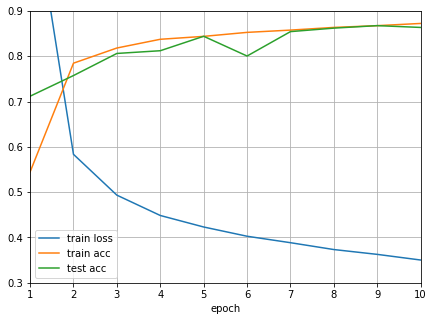

In [23]:
num_epochs, lr, batch_size = 10, 0.5, 256
loss = gluon.loss.SoftmaxCrossEntropyLoss()
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs,
              lambda batch_size: d2l.sgd(params, lr, batch_size))

### 4.6.5 Concise Implementation
Using `Gluon`, all we need to do is add a `Dropout` layer (also in the `nn` package) after each fully-connected layer, passing in the dropout probability as the only argument to its constructor. During training, the `Dropout` layer will randomly drop out outputs of the previous layer (or equivalently, the inputs to the subsequent layer) according to the specified dropout probability. When `MXNet` is not in training mode, the `Dropout` layer simply passes the data through during testing.

In [24]:
net = nn.Sequential()
net.add(nn.Dense(256, activation="relu"),
        # Add a dropout layer after the first fully connected layer
        nn.Dropout(dropout1),
        nn.Dense(256, activation="relu"),
        # Add a dropout layer after the second fully connected layer
        nn.Dropout(dropout2),
        nn.Dense(10))
net.initialize(init.Normal(sigma=0.01))

Next, we train and test the model.

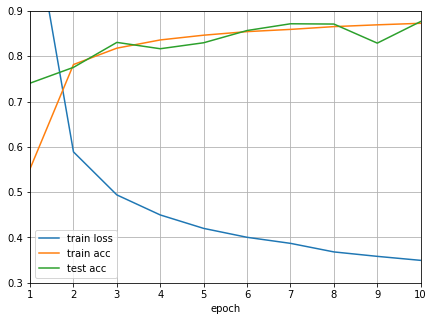

In [25]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

##### Summary
+ Beyond controlling the number of dimensions and the size of the weight vector, dropout is yet another tool to avoid overfitting. Often all three are used jointly.
+ Dropout replaces an activation $h$ with a random variable $h'$ with expected value $h$ and with variance given by the dropout probability $p$.
+ Dropout is only used during training.

##### Exercises
1. What happens if you change the dropout probabilities for layers 1 and 2? In particular, what happens if you switch the ones for both layers? Design an experiment to answer these questions, describe your results quantitatively, and summarize the qualitative takeaways.
2. Increase the number of epochs and compare the results obtained when using dropout with those when not using it.
3. What is the variance of the activations in each hidden layer when dropout is and is not applied? Draw a plot to show how this quantity evolves over time for both models.
4. Why is dropout not typically used at test time?
5. Using the model in this section as an example, compare the effects of using dropout and weight decay. What happens when dropout and weight decay are used at the same time? Are the results additive, are there diminished returns or (worse), do they cancel each other out?
6. What happens if we apply dropout to the individual weights of the weight matrix rather than the activations?
7. Invent another technique for injecting random noise at each layer that is different from the standard dropout technique. Can you develop a method that outperforms dropout on the Fashion-MNIST dataset (for a fixed architecture)?


## 4.7 Forward Propagation, Backward Propagation, and Computational Graphs
> 参考中文版`3.14`

So far, we have trained our models with minibatch stochastic gradient descent. However, when we implemented the algorithm, we only worried about the calculations involved in `forward propagation` through the model. When it came time to calculate the gradients, we just invoked the `backward` function, relying on the `autograd` module to know what to do.

The automatic calculation of gradients profoundly simplifies the implementation of deep learning algorithms. Before automatic differentiation, even small changes to complicated models required recalculating complicated derivatives by hand. Surprisingly often, academic papers had to allocate numerous pages to deriving update rules. While we must continue to rely on `autograd` so we can focus on the interesting parts, you ought to know how these gradients are calculated under the hood if you want to go beyond a shallow understanding of deep learning.

In this section, we take a deep dive into the details of backward propagation (more commonly called `backpropagation` or `backprop`). To convey some insight for both the techniques and their implementations, we rely on some basic mathematics and computational graphs. To start, we focus our exposition on a three layer (one hidden) multilayer perceptron with weight decay ($\ell_2$ regularization).

### 4.7.1 Forward Propagation
Forward propagation refers to the calculation and storage of intermediate variables (including outputs) for the neural network in order from the input layer to the output layer. We now work step-by-step through the mechanics of a deep network with one hidden layer. This may seem tedious but in the eternal words of funk virtuoso James Brown, you must "pay the cost to be the boss".

For the sake of simplicity, let’s assume that the input example is $\mathbf{x}\in\mathbb{R}^d$ and that our hidden layer does not include a bias term. Here the intermediate variable is:
$$\mathbf{z}= \mathbf{W}^{(1)} \mathbf{x},$$

where $\mathbf{W}^{(1)} \in \mathbb{R}^{h \times d}$ is the weight parameter of the hidden layer. After running the intermediate variable $\mathbf{z}\in \mathbb{R}^h$ through the activation function $\phi$ we obtain our hidden activation vector of length $h$,
$$\mathbf{h}= \phi (\mathbf{z}).$$

The hidden variable $\mathbf{h}$ is also an intermediate variable. Assuming the parameters of the output layer only possess a weight of $\mathbf{W}^{(2)} \in \mathbb{R}^{q \times h}$, we can obtain an output layer variable with a vector of length $q$:
$$\mathbf{o}= \mathbf{W}^{(2)} \mathbf{h}.$$

Assuming the loss function is $l$ and the example label is $y$, we can then calculate the loss term for a single data example,
$$L = l(\mathbf{o}, y).$$

According to the definition of $\ell_2$ regularization, given the hyperparameter $\lambda$, the regularization term is
$$s = \frac{\lambda}{2} \left(\Vert\mathbf{W}^{(1)}\Vert_F^2 + \Vert\mathbf{W}^{(2)}\Vert_F^2\right),$$

where the Frobenius norm of the matrix is simply the $L_2$ norm applied after flattening the matrix into a vector. Finally, the model's regularized loss on a given data example is:
$$J = L + s.$$

We refer to $J$ the objective function in the following discussion.

### 4.7.2 Computational Graph of Forward Propagation
Plotting computational graphs helps us visualize the dependencies of operators and variables within the calculation. `Fig. 4.7.1` contains the graph associated with the simple network described above. The lower-left corner signifies the input and the upper right corner the output. Notice that the direction of the arrows (which illustrate data flow) are primarily rightward and upward.

<img src="images/04_05.png" style="width:500px;"/>

### 4.7.3 Backpropagation
`Backpropagation` refers to the method of calculating the gradient of neural network parameters. In short, the method traverses the network in reverse order, from the output to the input layer, according to the chain rule from calculus. The algorithm stores any intermediate variables (partial derivatives) requried while calculating the gradient with respect to some parameters. Assume that we have functions $\mathsf{Y}=f(\mathsf{X})$ and $\mathsf{Z}=g(\mathsf{Y}) = g \circ f(\mathsf{X})$, in which the input and the output $\mathsf{X}, \mathsf{Y}, \mathsf{Z}$ are tensors of arbitrary shapes. By using the chain rule, we can compute the derivative of $\mathsf{Z}$ wrt. $\mathsf{X}$ via
$$\frac{\partial \mathsf{Z}}{\partial \mathsf{X}} = \text{prod}\left(\frac{\partial \mathsf{Z}}{\partial \mathsf{Y}}, \frac{\partial \mathsf{Y}}{\partial \mathsf{X}}\right).$$

Here we use the $\text{prod}$ operator to multiply its arguments after the necessary operations, such as transposition and swapping input positions, have been carried out. For vectors, this is straightforward: it is simply matrix-matrix multiplication. For higher dimensional tensors, we use the appropriate counterpart. The operator $\text{prod}$ hides all the notation overhead.

The parameters of the simple network with one hidden layer are $\mathbf{W}^{(1)}$ and $\mathbf{W}^{(2)}$. The objective of backpropagation is to calculate the gradients $\displaystyle\frac{\partial J}{\partial\mathbf{W}^{(1)}}$ and $\displaystyle\frac{\partial J}{\partial\mathbf{W}^{(2)}}$. To accomplish this, we apply the chain rule and calculate, in turn, the gradient of each intermediate variable and parameter. The order of calculations are reversed relative to those performed in forward propagation, since we need to start with the outcome of the compute graph and work our way towards the parameters. The first step is to calculate the gradients of the objective function $J=L+s$ with respect to the loss term $L$ and the regularization term $s$.
$$\frac{\partial J}{\partial L} = 1 ; \text{and} ; \frac{\partial J}{\partial s} = 1.$$

Next, we compute the gradient of the objective function with respect to variable of the output layer $\mathbf{o}$ according to the chain rule.
$$ \frac{\partial J}{\partial \mathbf{o}} = \text{prod}\left(\frac{\partial J}{\partial L}, \frac{\partial L}{\partial \mathbf{o}}\right) = \frac{\partial L}{\partial \mathbf{o}} \in \mathbb{R}^q. $$

Next, we calculate the gradients of the regularization term with respect to both parameters.

$$\frac{\partial s}{\partial \mathbf{W}^{(1)}} = \lambda \mathbf{W}^{(1)} ; \text{and} ; \frac{\partial s}{\partial \mathbf{W}^{(2)}} = \lambda \mathbf{W}^{(2)}.$$

Now we are able calculate the gradient $\displaystyle\frac{\partial J}{\partial \mathbf{W}^{(2)}} \in \mathbb{R}^{q \times h}$ of the model parameters closest to the output layer. Using the chain rule yields:
$$ \frac{\partial J}{\partial \mathbf{W}^{(2)}} = \text{prod}\left(\frac{\partial J}{\partial \mathbf{o}}, \frac{\partial \mathbf{o}}{\partial \mathbf{W}^{(2)}}\right) + \text{prod}\left(\frac{\partial J}{\partial s}, \frac{\partial s}{\partial \mathbf{W}^{(2)}}\right) = \frac{\partial J}{\partial \mathbf{o}} \mathbf{h}^\top + \lambda \mathbf{W}^{(2)}. $$

To obtain the gradient with respect to $\mathbf{W}^{(1)}$ we need to continue backpropagation along the output layer to the hidden layer. The gradient with respect to the hidden layer's outputs $\displaystyle\frac{\partial J}{\partial \mathbf{h}} \in \mathbb{R}^h$ is given by
$$ \frac{\partial J}{\partial \mathbf{h}} = \text{prod}\left(\frac{\partial J}{\partial \mathbf{o}}, \frac{\partial \mathbf{o}}{\partial \mathbf{h}}\right) = {\mathbf{W}^{(2)}}^\top \frac{\partial J}{\partial \mathbf{o}}. $$

Since the activation function $\phi$ applies elementwise, calculating the gradient $\displaystyle\frac{\partial J}{\partial\mathbf{z}} \in \mathbb{R}^h$ of the intermediate variable $\mathbf{z}$ requires that we use the elementwise multiplication operator, which we denote by $\odot$.
$$ \frac{\partial J}{\partial \mathbf{z}} = \text{prod}\left(\frac{\partial J}{\partial \mathbf{h}}, \frac{\partial \mathbf{h}}{\partial \mathbf{z}}\right) = \frac{\partial J}{\partial \mathbf{h}} \odot \phi'\left(\mathbf{z}\right). $$

Finally, we can obtain the gradient $\displaystyle\frac{\partial J}{\partial \mathbf{W}^{(1)}} \in \mathbb{R}^{h \times d}$ of the model parameters closest to the input layer. According to the chain rule, we get
$$ \frac{\partial J}{\partial \mathbf{W}^{(1)}} = \text{prod}\left(\frac{\partial J}{\partial \mathbf{z}}, \frac{\partial \mathbf{z}}{\partial \mathbf{W}^{(1)}}\right) + \text{prod}\left(\frac{\partial J}{\partial s}, \frac{\partial s}{\partial \mathbf{W}^{(1)}}\right) = \frac{\partial J}{\partial \mathbf{z}} \mathbf{x}^\top + \lambda \mathbf{W}^{(1)}. $$

### 4.7.4 Training a Model
When training networks, forward and backward propagation depend on each other. In particular, for forward propagation, we traverse the compute graph in the direction of dependencies and compute all the variables on its path. These are then used for backpropagation where the compute order on the graph is reversed. One of the consequences is that we need to retain the intermediate values until backpropagation is complete. This is also one of the reasons why backpropagation requires significantly more memory than plain prediction. We compute tensors as gradients and need to retain all the intermediate variables to invoke the chain rule. Another reason is that we typically train with minibatches containing more than one variable, thus more intermediate activations need to be stored.

##### Summary
+ Forward propagation sequentially calculates and stores intermediate variables within the compute graph defined by the neural network. It proceeds from input to output layer.
+ Back propagation sequentially calculates and stores the gradients of intermediate variables and parameters within the neural network in the reversed order.
+ When training deep learning models, forward propagation and back propagation are interdependent.
+ Training requires significantly more memory and storage.

##### Exercises
1. Assume that the inputs $\mathbf{x}$ to some scalar function $f$ are $n \times m$ matrices. What is the dimensionality of the gradient of $f$ with respect to $\mathbf{x}$?
2. Add a bias to the hidden layer of the model described in this section.
    + Draw the corresponding compute graph.
    + Derive the forward and backward propagation equations.
3. Compute the memory footprint for training and inference in model described in the current chapter.
4. Assume that you want to compute second derivatives. What happens to the compute graph? How long do you expect the calculation to take?
5. Assume that the compute graph is too large for your GPU.
    + Can you partition it over more than one GPU?
    + What are the advantages and disadvantages over training on a smaller minibatch?

## 4.8 Numerical Stability and Initialization
Thus far, every model that we have implemented required that we initialize its parameters according to some pre-specified distribution. Until now, we took the initialization scheme for granted, glossing over the details of how these these choices are made. You might have even gotten the impression that these choices are not especially important. To the contrary, the choice of initialization scheme plays a significant role in neural network learning, and it can be crucial for maintaining numerical stability. Moreover, these choices can be tied up in interesting ways with the choice of the nonlinear activation function. Which function we choose and how we initialize parameters can determine how quickly our optimization algorithm converges. Poor choices here can cause us to encounter exploding or vanishing gradients while training. In this section, we delve into these topics with greater detail and discuss some useful heuristics that you will find useful throughout your career in deep learning.

### 4.8.1 Vanishing and Exploding Gradients
Consider a deep network with $L$ layers, input $\mathbf{x}$ and output $\mathbf{o}$. With each layer $l$ defined by a transformation $f_l$ parameterized by weights $\mathbf{W}_l$ our network can be expressed as:
$$\displaystyle\mathbf{h}^{l+1} = f_l (\mathbf{h}^l) \text{ and thus } \mathbf{o} = f_L \circ \ldots, \circ f_1(\mathbf{x}).$$

If all activations and inputs are vectors, we can write the gradient of $\mathbf{o}$ with respect to any set of parameters $\mathbf{W}_l$ as follows:
$$\displaystyle\partial_{\mathbf{W}l} \mathbf{o} = \underbrace{\partial{\mathbf{h}^{L-1}} \mathbf{h}^L}_{:= \mathbf{M}L} \cdot \ldots, \cdot \underbrace{\partial{\mathbf{h}^{l}} \mathbf{h}^{l+1}}_{:= \mathbf{M}l} \underbrace{\partial{\mathbf{W}l} \mathbf{h}^l}_{:= \mathbf{v}_l}.$$

In other words, this gradient is the product of $L-l$ matrices $\mathbf{M}_L \cdot \ldots, \cdot \mathbf{M}_l$ and the gradient vector $\mathbf{v}_l$. Thus we are susceptible to the same problems of numerical underflow that often crop up when multiplying together too many probabilities. When dealing with probabilities, a common trick is to switch into log-space, i.e., shifting pressure from the mantissa to the exponent of the numerical representation. Unfortunately, our problem above is more serious: initially the matrices $M_l$ may have a wide variety of eigenvalues. They might be small or large, and their product might be *very large* or *very small*.

The risks posed by unstable gradients go beyond numerical representation. Gradients of unpredictable magnitude also threaten the stability of our optimization algorithms. We may be facing parameter updates that are either (i) excessively large, destroying our model (the exploding gradient problem); or (ii) excessively small (the vanishing gradient problem), rendering learning impossible as parameters hardly move on each update.

##### Vanishing Gradients
One frequent culprit causing the vanishing gradient problem is the choice of the activation function $\sigma$ that is appended following each layer's linear operations. Historically, the sigmoid function $1/(1 + \exp(-x))$ (introduced in `Section 4.1`) was popular because it resembles a thresholding function. Since early artificial neural networks were inspired by biological neural networks, the idea of neurons that fire either fully or not at all (like biological neurons) seemed appealing. Let us take a closer look at the sigmoid to see why it can cause vanishing gradients.

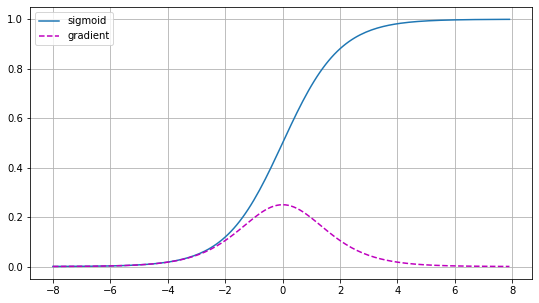

In [26]:
x = np.arange(-8.0, 8.0, 0.1)
x.attach_grad() 

with autograd.record():
    y = npx.sigmoid(x) 
y.backward()

d2l.plot(x, [y, x.grad], legend=['sigmoid', 'gradient'], figsize=(9, 5))

As you can see, the sigmoid's gradient vanishes both when its inputs are large and when they are small. Moreover, when backpropagating through many layers, unless we are in the Goldilocks zone, where the inputs to many of the sigmoids are close to zero, the gradients of the overall product may vanish. When our network boasts many layers, unless we are careful, the gradient will likely be cut off at some layer. Indeed, this problem used to plague deep network training. Consequently, ReLUs, which are more stable (but less neurally plausible), have emerged as the default choice for practitioners.

##### Exploding Gradients
The opposite problem, when gradients explode, can be similarly vexing. To illustrate this a bit better, we draw $100$ Gaussian random matrices and multiply them with some initial matrix. For the scale that we picked (the choice of the variance $\sigma^2=1$), the matrix product explodes. When this happens due to the initialization of a deep network, we have no chance of getting a gradient descent optimizer to converge.

In [27]:
M = np.random.normal(size=(4, 4))
print('A single matrix', M)
for i in range(100):
    M = np.dot(M, np.random.normal(size=(4, 4)))

print('After multiplying 100 matrices', M)

A single matrix [[-0.7717086  -0.5023264  -0.41853794 -0.07484963]
 [-1.5069818   1.0422391   0.07954166 -0.6294196 ]
 [-0.21422288 -0.04638499  1.49719    -0.9850284 ]
 [ 0.79923075  0.31565008  1.1020358   2.1143765 ]]
After multiplying 100 matrices [[ 1.8769063e+25 -1.2344499e+25 -1.9923949e+24 -2.2862869e+25]
 [ 5.5789484e+25 -3.6693004e+25 -5.9222280e+24 -6.7957990e+25]
 [-5.1469995e+25  3.3852056e+25  5.4637048e+24  6.2696351e+25]
 [-7.3679040e+24  4.8459038e+24  7.8212574e+23  8.9749503e+24]]


##### Symmetry
Another problem in deep network design is the symmetry inherent in their parametrization. Assume that we have a deep network with one hidden layer and two units, say $h_1$ and $h_2$. In this case, we could permute the weights $\mathbf{W}_1$ of the first layer and likewise permute the weights of the output layer to obtain the same function. There is nothing special differentiating the first hidden unit vs the second hidden unit. In other words, we have permutation symmetry among the hidden units of each layer.

This is more than just a theoretical nuisance. Imagine what would happen if we initialized all of the parameters of some layer as $\mathbf{W}_l = c$ for some constant $c$. In this case, the gradients for all dimensions are identical: thus not only would each unit take the same value, but it would receive the same update. Stochastic gradient descent would never break the symmetry on its own and we might never be able to realize the network's expressive power. The hidden layer would behave as if it had only a single unit. Note that while SGD would not break this symmetry, dropout regularization would!

### 4.8.2 Parameter Initialization
One way of addressing---or at least mitigating---the issues raised above is through careful initialization. Additional care during optimization and suitable regularization can further enhance stability.

##### Default Initialization
In the previous sections, e.g., in `Section 3.3`, we used `net.initialize(init.Normal(sigma=0.01))` to initialize the values of our weights. If the initialization method is not specified, such as `net.initialize()`, `MXNet` will use the default random initialization method, sampling each weight parameter from the uniform distribution $U[-0.07, 0.07]$ and setting the bias parameters to $0$. Both choices tend to work well in practice for moderate problem sizes.

##### Xavier Initialization
> 这里写的不清楚，参考我的文章<<Xavier原理>>

Let us look at the scale distribution of the activations of the hidden units $h_{i}$ for some layer. They are given by
$$h_{i} = \sum_{j=1}^{n_\mathrm{in}} W_{ij} x_j.$$

The weights $W_{ij}$ are all drawn independently from the same distribution. Furthermore, let us assume that this distribution has zero mean and variance $\sigma^2$ (this does not mean that the distribution has to be Gaussian, just that the mean and variance need to exist). For now, let us assume that the inputs to layer $x_j$ also have zero mean and variance $\gamma^2$ and that they are independent of $\mathbf{W}$. In this case, we can compute the mean and variance of $h_i$ as follows:
$$ \begin{aligned} E[h_i] & = \sum_{j=1}^{n_\mathrm{in}} E[W_{ij} x_j] = 0, \\ E[h_i^2] & = \sum_{j=1}^{n_\mathrm{in}} E[W^2_{ij} x^2_j] \\ & = \sum_{j=1}^{n_\mathrm{in}} E[W^2_{ij}] E[x^2_j] \\ & = n_\mathrm{in} \sigma^2 \gamma^2. \end{aligned} $$

One way to keep the variance fixed is to set $n_\mathrm{in} \sigma^2 = 1$. Now consider backpropagation. There we face a similar problem, albeit with gradients being propagated from the top layers. That is, instead of $\mathbf{W} \mathbf{x}$, we need to deal with $\mathbf{W}^\top \mathbf{g}$, where $\mathbf{g}$ is the incoming gradient from the layer above. Using the same reasoning as for forward propagation, we see that the gradients' variance can blow up unless $n_\mathrm{out} \sigma^2 = 1$. This leaves us in a dilemma: we cannot possibly satisfy both conditions simultaneously. Instead, we simply try to satisfy:

$$ \begin{aligned} \frac{1}{2} (n_\mathrm{in} + n_\mathrm{out}) \sigma^2 = 1 \text{ or equivalently } \sigma = \sqrt{\frac{2}{n_\mathrm{in} + n_\mathrm{out}}}. \end{aligned} $$

This is the reasoning underlying the now-standard and practically beneficial `Xavier` initialization, named for its creator (`Glorot.Bengio.2010`). Typically, the `Xavier` initialization samples weights from a Gaussian distribution with zero mean and variance $\sigma^2 = \displaystyle\frac{2}{(n_\mathrm{in} + n_\mathrm{out})}$. We can also adapt `Xavier`'s intuition to choose the variance when sampling weights from a uniform distribution. Note the distribution $U[-a, a]$ has variance $\displaystyle{a^2}{3}$. Plugging $\displaystyle\frac{a^2}{3}$ into our condition on $\sigma^2$ yields the suggestion to initialize according to $U\left[-\sqrt{6/(n_\mathrm{in} + n_\mathrm{out})}, \sqrt{6/(n_\mathrm{in} + n_\mathrm{out})}\right]$.

##### Beyond
The reasoning above barely scratches the surface of modern approaches to parameter initialization. In fact, `MXNet` has an entire `mxnet.initializer` module implementing over a dozen different heuristics. Moreover, parameter initialization continues to be a hot area of fundamental research in deep learning. Among these are heuristics specialized for tied (shared) parameters, super-resolution, sequence models, and other situations. If the topic interests you we suggest a deep dive into this module's offerings, reading the papers that proposed and analyzed each heuristic, and then exploring the latest publications on the topic. Perhaps you will stumble across (or even invent!) a clever idea and contribute an implementation to `MXNet`.

##### Summary
+ Vanishing and exploding gradients are common issues in deep networks. Great care in parameter initialization is required to ensure that gradients and parameters remain well controlled.
+ Initialization heuristics are needed to ensure that the initial gradients are neither too large nor too small.
+ ReLU activation functions mitigate the vanishing gradient problem. This can accelerate convergence.
+ Random initialization is key to ensure that symmetry is broken before optimization.

##### Exercises
1. Can you design other cases where a neural network might exhibit symmetry requiring breaking besides the permutation symmetry in a multilayer pereceptron's layers?
2. Can we initialize all weight parameters in linear regression or in softmax regression to the same value?
3. Look up analytic bounds on the eigenvalues of the product of two matrices. What does this tell you about ensuring that gradients are well conditioned?
4. If we know that some terms diverge, can we fix this after the fact? Look at the paper on LARS for inspiration (You et al., 2017).

## 4.9 Considering the Environment
In the previous chapters, we worked through a number of hands-on applications of machine learning, fitting models to a variety of datasets. And yet, we never stopped to contemplate either where data comes from in the first place or what we plan to ultimately do with the outputs from our models. Too often, machine learning developers in possession of data rush to develop models without pausing to consider these fundamental issues.

Many failed machine learning deployments can be traced back to this pattern. Sometimes models appear to perform marvelously as measured by test set accuracy but fail catastrophically in deployment when the distribution of data suddenly shifts. More insidiously, sometimes the very deployment of a model can be the catalyst that perturbs the data distribution. Say, for example, that we trained a model to predict who will repay vs default on a loan, finding that an applicant's choice of footware was associated with the risk of default (Oxfords indicate repayment, sneakers indicate default). We might be inclined to thereafter grant loans to all applicants wearing Oxfords and to deny all applicants wearing sneakers.

In this case, our ill-considered leap from pattern recognition to decision-making and our failure to critically consider the environment might have disastrous consequences. For starters, as soon as we began making decisions based on footware, customers would catch on and change their behavior. Before long, all applicants would be wearing Oxfords, without any coinciding improvement in credit-worthiness. Take a minute to digest this because similar issues abound in many applications of machine learning: by introducing our model-based decisions to the environment, we might break the model.

While we cannot possibly give these topics a complete treatment in one section, we aim here to expose some common concerns, and to stimulate the critical thinking required to detect these situations early, mitigate damage, and use machine learning responsibly. Some of the solutions are simple (ask for the "right" data), some are technically difficult (implement a reinforcement learning system), and others require that we step outside the realm of statistical prediction altogether and grapple with difficult philosophical questions concerning the ethical application of algorithms.

### 4.9.1 Distribution Shift
To begin, we stick with the passive predictions setting considering the various ways that data distributions might shift and what might be done to salvage model performance. In one classic setup, we assume that our training data was sampled from some distribution $p_S(\mathbf{x},y)$ but that our test data will consist of unlabeled examples drawn from some different distribution $p_T(\mathbf{x},y)$. Already, we must confront a sobering reality. Absent any assumptions on how $p_S$ and $p_T$ relate to each other, learning a robust classifier is impossible.

Consider a binary classification problem, where we wish to distinguish between dogs and cats. If the distribution can shift in arbitrary ways, then our setup permits the pathological case in which the distribution over inputs remains constant: $p_S(\mathbf{x}) = p_T(\mathbf{x})$ but the labels are all flipped $p_S(y|\mathbf{x}) = 1-p_T(y|\mathbf{x})$. In other words, if God can suddenly decide that in the future all "cats" are now dogs and what we previously called "dogs" are now cats---without any change in the distribution of inputs $p(\mathbf{x})$, then we cannot possibly distinguish this setting from one in which the distribution did not change at all.

Fortunately, under some restricted assumptions on the ways our data might change in the future, principled algorithms can detect shift and sometimes even adapt on the fly, improving on the accuracy of the original classifier.

##### Covariate Shift
Among categories of distribution shift, `covariate shift` may be the most widely studied. Here, we assume that while the distribution of inputs may change over time, the labeling function, i.e., the conditional distribution $P(y \mid \mathbf{x})$ does not change. Statisticians call this covariate shift because the problem arises due to a a shift in the distribution of the covariates (the features). While we can sometimes reason about distribution shift without invoking causality, we note that covariate shift is the natural assumption to invoke in settings where we believe that $\mathbf{x}$ causes $y$.

Consider the challenge of distinguishing cats and dogs. Our training data might consist of images of the following kind:

<img src="images/04_06.png" style="width:500px;"/>

At test time we are asked to classify the following images:

<img src="images/04_07.png" style="width:500px;"/>

The training set consists of photos, while the test set contains only cartoons. Training on a dataset with substantially different characteristics from the test set can spell trouble absent a coherent plan for how to adapt to the new domain.

##### Label Shift
`Label shift` describes the converse problem. Here, we assume that the label marginal $P(y)$ can change (inducing a change in $P(\mathbf{x})$) but the class-conditional distribution $P(\mathbf{x} \mid y)$ remains fixed across domains. Label shift is a reasonable assumption to make when we believe that $y$ causes $\mathbf{x}$. For example, we may want to predict diagnoses given their symptoms (or other manifestations), even as the relative prevalence of diagnoses are changing over time. Label shift is the appropriate assumption here because diseases cause symptoms. In some degenerate cases the label shift and covariate shift assumptions can hold simultaneously. For example, when the label is deterministic, the covariate shift assumption will be satisfied, even when $y$ causes $\mathbf{x}$. Interestingly, in these cases, it is often advantageous to work with methods that flow from the label shift assumption. That is because these methods tend to involve manipulating objects that look like the label (which is often low-dimensional), as opposed to objects that look like the input, which (in deep learning) tends to be high-dimensional.

##### Concept Shift
We may also encounter the related problem of concept shift, which arises when the very definitions of labels can change. This sounds weird---a cat is a cat, no? However, other categories are subject to changes in usage over time. Diagnostic criteria for mental illness, what passes for fashionable, and job titles, are all subject to considerable amounts of concept shift. It turns out that if we navigate around the United States, shifting the source of our data by geography, we will find considerable concept shift regarding the distribution of names for soft drinks as shown in `Fig. 4.9.1`.

<img src="images/04_08.png" style="width:500px;"/>

If we were to build a machine translation system, the distribution $P(y \mid x)$ might be different depending on our location. This problem can be tricky to spot. We might hope to exploit knowledge that shift only takes place gradually (either in a temporal or geographic sense).

##### Examples
Before delving into formalism and algorithms, we can discuss some concrete situations where covariate or concept shift might not be obvious.

**Medical Diagnostics**
Imagine that you want to design an algorithm to detect cancer. You collect data from healthy and sick people and you train your algorithm. It works fine, giving you high accuracy and you conclude that you’re ready for a successful career in medical diagnostics. Not so fast.

The distributions that gave rise to the training data and those you will encounter in the wild might differ considerably. This happened to an unfortunate startup that one of us worked with years ago. They were developing a blood test for a disease that predominantly affects older men and hoped to study it using blood samples that they had collected from patients. However, it is considerably more difficult to obtain blood samples from healthy men than sick patients already in the system. To compensate, the startup solicited blood donations from students on a university campus to serve as healthy controls in developing their test. Then they asked whether we could help them to build a classifier for detecting the disease.

As we explained to them, it would indeed be easy to distinguish between the healthy and sick cohorts with near-perfect accuracy. However, that's because the test subjects differed in age, hormone levels, physical activity, diet, alcohol consumption, and many more factors unrelated to the disease. This was unlikely to be the case with real patients. Due to their sampling procedure, we could expect to encounter extreme covariate shift. Moreover, this case was unlikely to be correctable via conventional methods. In short, they wasted a significant sum of money.

**Self Driving Cars** 
Say a company wanted to leverage machine learning for developing self-driving cars. One key component here is a roadside detector. Since real annotated data is expensive to get, they had the (smart and questionable) idea to use synthetic data from a game rendering engine as additional training data. This worked really well on "test data" drawn from the rendering engine. Alas, inside a real car it was a disaster. As it turned out, the roadside had been rendered with a very simplistic texture. More importantly, all the roadside had been rendered with the same texture and the roadside detector learned about this "feature" very quickly.

A similar thing happened to the US Army when they first tried to detect tanks in the forest. They took aerial photographs of the forest without tanks, then drove the tanks into the forest and took another set of pictures. The classifier appeared to work perfectly. Unfortunately, it had merely learned how to distinguish trees with shadows from trees without shadows---the first set of pictures was taken in the early morning, the second one at noon.

**Nonstationary distributions**
A much more subtle situation arises when the distribution changes slowly and the model is not updated adequately. Here are some typical cases:
+ We train a computational advertising model and then fail to update it frequently (e.g., we forget to incorporate that an obscure new device called an iPad was just launched).
+ We build a spam filter. It works well at detecting all spam that we have seen so far. But then the spammers wisen up and craft new messages that look unlike anything we have seen before.
+ We build a product recommendation system. It works throughout the winter but then continues to recommend Santa hats long after Christmas.

**More Anecdotes**
+ We build a face detector. It works well on all benchmarks. Unfortunately it fails on test data---the offending examples are close-ups where the face fills the entire image (no such data was in the training set).
+ We build a web search engine for the USA market and want to deploy it in the UK.
+ We train an image classifier by compiling a large dataset where each among a large set of classes is equally represented in the dataset, say 1000 categories, represented by 1000 images each. Then we deploy the system in the real world, where the actual label distribution of photographs is decidedly non-uniform.

In short, there are many cases where training and test distributions $p(\mathbf{x}, y)$ are different. In some cases, we get lucky and the models work despite covariate, label, or concept shift. In other cases, we can do better by employing principled strategies to cope with the shift. The remainder of this section grows considerably more technical. The impatient reader could continue on to the next section as this material is not prerequisite to subsequent concepts.

##### Covariate Shift Correction
Assume that we want to estimate some dependency $P(y \mid \mathbf{x})$ for which we have labeled data $(\mathbf{x}_i, y_i)$. Unfortunately, the observations $x_i$ are drawn from some *target* distribution $q(\mathbf{x})$ rather than the *source* distribution $p(\mathbf{x})$. To make progress, we need to reflect about what exactly is happening during training: we iterate over training data and associated labels ${(\mathbf{x}_1, y_1), \ldots, (\mathbf{x}_n, y_n)}$ and update the weight vectors of the model after every minibatch. We sometimes additionally apply some penalty to the parameters, using weight decay, dropout, or some other related technique. This means that we largely minimize the loss on the training.
$$\displaystyle\mathop{\mathrm{minimize}}_w \frac{1}{n} \sum_{i=1}^n l(x_i, y_i, f(x_i)) + \mathrm{some~penalty}(w). $$

Statisticians call the first term an `empirical average`, i.e., an average computed over the data drawn from $P(x) P(y \mid x)$. If the data is drawn from the "wrong" distribution $q$, we can correct for that by using the following simple identity:
$$ \begin{aligned} \int p(\mathbf{x}) f(\mathbf{x}) dx & = \int q(\mathbf{x}) f(\mathbf{x}) \frac{p(\mathbf{x})}{q(\mathbf{x})} dx. \end{aligned} $$

In other words, we need to re-weight each instance by the ratio of probabilities that it would have been drawn from the correct distribution $\displaystyle\beta(\mathbf{x}) := \frac{p(\mathbf{x})}{q(\mathbf{x})}$. Alas, we do not know that ratio, so before we can do anything useful we need to estimate it. Many methods are available, including some fancy operator-theoretic approaches that attempt to recalibrate the expectation operator directly using a minimum-norm or a maximum entropy principle. Note that for any such approach, we need samples drawn from both distributions---the "true" $p$, e.g., by access to training data, and the one used for generating the training set $q$ (the latter is trivially available). Note however, that we only need samples $\mathbf{x} \sim q(\mathbf{x})$; we do not to access labels $y \sim q(y)$.

In this case, there exists a very effective approach that will give almost as good results: `logistic regression`. This is all that is needed to compute estimate probability ratios. We learn a classifier to distinguish between data drawn from $p(\mathbf{x})$ and data drawn from $q(\mathbf{x})$. If it is impossible to distinguish between the two distributions then it means that the associated instances are equally likely to come from either one of the two distributions. On the other hand, any instances that can be well discriminated should be significantly overweighted or underweighted accordingly. For simplicity’s sake assume that we have an equal number of instances from both distributions, denoted by $\mathbf{x}_i \sim p(\mathbf{x})$ and $\mathbf{x}_i' \sim q(\mathbf{x})$, respectively. Now denote by $z_i$ labels that are 1 for data drawn from $p$ and -1 for data drawn from $q$. Then the probability in a mixed dataset is given by

$$P(z=1 \mid \mathbf{x}) = \frac{p(\mathbf{x})}{p(\mathbf{x})+q(\mathbf{x})} \text{ and hence } \frac{P(z=1 \mid \mathbf{x})}{P(z=-1 \mid \mathbf{x})} = \frac{p(\mathbf{x})}{q(\mathbf{x})}.$$

Hence, if we use a logistic regression approach, where 
$$P(z=1 \mid \mathbf{x})=\frac{1}{1+\exp(-f(\mathbf{x}))}$$. 

it follows that

$$ \beta(\mathbf{x}) = \frac{1/(1 + \exp(-f(\mathbf{x})))}{\exp(-f(\mathbf{x}))/(1 + \exp(-f(\mathbf{x})))} = \exp(f(\mathbf{x})). $$

As a result, we need to solve two problems: first one to distinguish between data drawn from both distributions, and then a reweighted minimization problem where we weigh terms by $\beta$, e.g., via the head gradients. Here's a prototypical algorithm for that purpose which uses an unlabeled training set $X$ and test set $Z$:
1. Generate training set with ${(\mathbf{x}_i, -1) ... (\mathbf{z}_j, 1)}$.
2. Train binary classifier using logistic regression to get function $f$.
3. Weigh training data using $\beta_i = \exp(f(\mathbf{x}_i))$ or better $\beta_i = \min(\exp(f(\mathbf{x}_i)), c)$.
4. Use weights $\beta_i$ for training on $X$ with labels $Y$.

Note that this method relies on a crucial assumption. For this scheme to work, we need that each data point in the target (test time) distribution had nonzero probability of occurring at training time. If we find a point where $q(\mathbf{x}) > 0$ but $p(\mathbf{x}) = 0$, then the corresponding importance weight should be infinity.

Generative Adversarial Networks use a very similar idea to that described above to engineer a data generator that outputs data that cannot be distinguished from examples sampled from a reference dataset. In these approaches, we use one network, $f$ to distinguish real versus fake data and a second network $g$ that tries to fool the discriminator $f$ into accepting fake data as real. We will discuss this in much more detail later.

##### Label Shift Correction
Assume that we are dealing with a $k$-way multiclass classification task. When the distribution of labels shifts over time, $p(y) \neq q(y)$ but the class-conditional distributions stay the same $p(\mathbf{x})=q(\mathbf{x})$. Here, our importance weights will correspond to the label likelihood ratios $q(y)/p(y)$. One nice thing about label shift is that if we have a reasonably good model (on the source distribution) then we can get consistent estimates of these weights without ever having to deal with the ambient dimension In deep learning, the inputs tend to be high-dimensional objects like images, while the labels are often simpler objects like categories.

To estimate the target label distribution, we first take our reasonably good off the shelf classifier (typically trained on the training data) and compute its confusion matrix using the validation set (also from the training distribution). The confusion matrix, C, is simply a $k \times k$ matrix, where each column corresponds to the actual label and each row corresponds to our model's predicted label. Each cell's value $c_{ij}$ is the fraction of predictions where the true label was $j$ and our model predicted $i$.

Now, we cannot calculate the confusion matrix on the target data directly, because we do not get to see the labels for the examples that we see in the wild, unless we invest in a complex real-time annotation pipeline. What we can do, however, is average all of our models predictions at test time together, yielding the mean model output $\mu_y$.

It turns out that under some mild conditions---if our classifier was reasonably accurate in the first place, and if the target data contains only classes of images that we have seen before, and if the label shift assumption holds in the first place (the strongest assumption here), then we can recover the test set label distribution by solving a simple linear system $C \cdot q(y) = \mu_y$. If our classifier is sufficiently accurate to begin with, then the confusion $C$ will be invertible, and we get a solution $q(y) = C^{-1} \mu_y$. Here we abuse notation a bit, using $q(y)$ to denote the vector of label frequencies. Because we observe the labels on the source data, it is easy to estimate the distribution $p(y)$. Then for any training example $i$ with label $y$, we can take the ratio of our estimates $\hat{q}(y)/\hat{p}(y)$ to calculate the weight $w_i$, and plug this into the weighted risk minimization algorithm above.

##### Concept Shift Correction
Concept shift is much harder to fix in a principled manner. For instance, in a situation where suddenly the problem changes from distinguishing cats from dogs to one of distinguishing white from black animals, it will be unreasonable to assume that we can do much better than just collecting new labels and training from scratch. Fortunately, in practice, such extreme shifts are rare. Instead, what usually happens is that the task keeps on changing slowly. To make things more concrete, here are some examples:

In computational advertising, new products are launched, old products become less popular. This means that the distribution over ads and their popularity changes gradually and any click-through rate predictor needs to change gradually with it.
Traffic camera lenses degrade gradually due to environmental wear, affecting image quality progressively.
News content changes gradually (i.e., most of the news remains unchanged but new stories appear).
In such cases, we can use the same approach that we used for training networks to make them adapt to the change in the data. In other words, we use the existing network weights and simply perform a few update steps with the new data rather than training from scratch.

### 4.9.2 A Taxonomy of Learning Problems
Armed with knowledge about how to deal with changes in $p(x)$ and in $P(y \mid x)$, we can now consider some other aspects of machine learning problem formulation.
+ **Batch Learning**. Here we have access to training data and labels ${(x_1, y_1), \ldots, (x_n, y_n)}$, which we use to train a network $f(x, w)$. Later on, we deploy this network to score new data $(x, y)$ drawn from the same distribution. This is the default assumption for any of the problems that we discuss here. For instance, we might train a cat detector based on lots of pictures of cats and dogs. Once we trained it, we ship it as part of a smart catdoor computer vision system that lets only cats in. This is then installed in a customer's home and is never updated again (barring extreme circumstances).

+ **Online Learning**. Now imagine that the data $(x_i, y_i)$ arrives one sample at a time. More specifically, assume that we first observe $x_i$, then we need to come up with an estimate $f(x_i, w)$ and only once we have done this, we observe $y_i$ and with it, we receive a reward (or incur a loss), given our decision. Many real problems fall into this category. E.g., we need to predict tomorrow's stock price, this allows us to trade based on that estimate and at the end of the day we find out whether our estimate allowed us to make a profit. In other words, we have the following cycle where we are continuously improving our model given new observations.

$$ \mathrm{model} ~ f_t \longrightarrow \mathrm{data} ~ x_t \longrightarrow \mathrm{estimate} ~ f_t(x_t) \longrightarrow \mathrm{observation} ~ y_t \longrightarrow \mathrm{loss} ~ l(y_t, f_t(x_t)) \longrightarrow \mathrm{model} ~ f_{t+1} $$

+ **Bandits**. They are a special case of the problem above. While in most learning problems we have a continuously parametrized function $f$ where we want to learn its parameters (e.g., a deep network), in a bandit problem we only have a finite number of arms that we can pull (i.e., a finite number of actions that we can take). It is not very surprising that for this simpler problem stronger theoretical guarantees in terms of optimality can be obtained. We list it mainly since this problem is often (confusingly) treated as if it were a distinct learning setting.

+ **Control (and nonadversarial Reinforcement Learning)**. In many cases the environment remembers what we did. Not necessarily in an adversarial manner but it will just remember and the response will depend on what happened before. E.g., a coffee boiler controller will observe different temperatures depending on whether it was heating the boiler previously. PID (proportional integral derivative) controller algorithms are a popular choice there. Likewise, a user's behavior on a news site will depend on what we showed him previously (e.g., he will read most news only once). Many such algorithms form a model of the environment in which they act such as to make their decisions appear less random (i.e., to reduce variance).

+ **Reinforcement Learning**. In the more general case of an environment with memory, we may encounter situations where the environment is trying to cooperate with us (cooperative games, in particular for non-zero-sum games), or others where the environment will try to win. Chess, Go, Backgammon or StarCraft are some of the cases. Likewise, we might want to build a good controller for autonomous cars. The other cars are likely to respond to the autonomous car's driving style in nontrivial ways, e.g., trying to avoid it, trying to cause an accident, trying to cooperate with it, etc.

One key distinction between the different situations above is that the same strategy that might have worked throughout in the case of a stationary environment, might not work throughout when the environment can adapt. For instance, an arbitrage opportunity discovered by a trader is likely to disappear once he starts exploiting it. The speed and manner at which the environment changes determines to a large extent the type of algorithms that we can bring to bear. For instance, if we know that things may only change slowly, we can force any estimate to change only slowly, too. If we know that the environment might change instantaneously, but only very infrequently, we can make allowances for that. These types of knowledge are crucial for the aspiring data scientist to deal with concept shift, i.e., when the problem that he is trying to solve changes over time.

### 4.9.3 Fairness, Accountability, and Transparency in Machine Learning
Finally, it is important to remember that when you deploy machine learning systems you are not merely optimizing a predictive model---you are typically providing a tool that will be used to (partially or fully) automate decisions. These technical systems can impact the lives of individuals subject to the resulting decisions. The leap from considering predictions to decisions raises not only new technical questions, but also a slew of ethical questions that must be carefully considered. If we are deploying a medical diagnostic system, we need to know for which populations it may work and which it may not. 

Overlooking foreseeable risks to the welfare of a subpopulation could cause us to administer inferior care. Moreover, once we contemplate decision-making systems, we must step back and reconsider how we evaluate our technology. Among other consequences of this change of scope, we will find that accuracy is seldom the right metric. For instance, when translating predictions into actions, we will often want to take into account the potential cost sensitivity of erring in various ways. If one way of misclassifying an image could be perceived as a racial sleight, while misclassification to a different category would be harmless, then we might want to adjust our thresholds accordingly, accounting for societal values in designing the decision-making protocol. We also want to be careful about how prediction systems can lead to feedback loops. For example, consider predictive policing systems, which allocate patrol officers to areas with high forecasted crime. It is easy to see how a worrying pattern can emerge:
1. Neighborhoods with more crime get more patrols.
2. Consequently, more crimes are discovered in these neighborhoods, entering the training data available for future iterations.
3. Exposed to more positives, the model predicts yet more crime in these neighborhoods.
4. In the next iteration, the updated model targets the same neighborhood even more heavily leading to yet more crimes discovered, etc.

Often, the various mechanisms by which a model's predictions become coupled to its training data are unaccounted for in the modeling process. This can lead to what researchers call `runaway feedback loops`. Additionally, we want to be careful about whether we are addressing the right problem in the first place. Predictive algorithms now play an outsize role in mediating the dissemination of information. Should the news that an individual encounters be determined by the set of Facebook pages they have Liked? These are just a few among the many pressing ethical dilemmas that you might encounter in a career in machine learning.

##### Summary
+ In many cases training and test sets do not come from the same distribution. This is called covariate shift.
+ Under the corresponding assumptions, covariate and label shift can be detected and corrected for at test time. Failure to account for this bias can become problematic at test time.
+ In some cases, the environment may remember automated actions and respond in surprising ways. We must account for this possibility when building models and continue to monitor live systems, open to the possibility that our models and the environment will become entangled in unanticipated ways.

##### Exercises
1. What could happen when we change the behavior of a search engine? What might the users do? What about the advertisers?
2. Implement a covariate shift detector. Hint: build a classifier.
3. Implement a covariate shift corrector.
4. What could go wrong if training and test sets are very different? What would happen to the sample weights?

## 4.10 Predicting House Prices on Kaggle
Now that we have introduced some basic tools for building and training deep networks and regularizing them with techniques including dimensionality reduction, weight decay, and dropout, we are ready to put all this knowledge into practice by participating in a Kaggle competition. Predicting house prices is a great place to start. The data is fairly generic and does not exhibit exotic structure that might require specialized models (as audio or video might). This dataset, collected by Bart de Cock in 2011 (`De-Cock.2011`), covers house prices in Ames, IA from the period of 2006-2010. It is considerably larger than the famous Boston housing dataset of Harrison and Rubinfeld (1978), boasting both more examples and more features.

In this section, we will walk you through details of data preprocessing, model design, and hyperparameter selection. We hope that through a hands-on approach, you will gain some intuitions that will guide you in your career as a data scientist.

### 4.10.1 Downloading and Caching Datasets
Throughout the book, we will train and test models on various downloaded datasets. Here, we implement several utility functions to facilitate data downloading. First, we maintain a dictionary `DATA_HUB` that maps a string (the name of the dataset) to a tuple containing both a URL to locate the dataset and a `SHA-1` key which we will use to verify the integrity of the file. All of our datasets are hosted on site whose address is assigned to `DATA_URL` below.

In [28]:
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

The following `download` function downloads the dataset, caching it in a local directory (in `../data` by default) and returns the name of the downloaded file. If a file corrsponding to this dataset already exists in the cache directory and its `SHA-1` matches the one stored in `DATA_HUB`, our code will use the cached file to avoid clogging up your internet with redundant downloads.

In [29]:
def download(name, cache_dir=os.path.join('..', 'data')):
    """Download a file inserted into DATA_HUB, return the local filename."""
    assert name in DATA_HUB, "%s does not exist" % name
    url, sha1 = DATA_HUB[name]
    d2l.mkdir_if_not_exist(cache_dir)
    return gluon.utils.download(url, cache_dir, sha1_hash=sha1)

We also implement two additional functions: one is to download and extract a zip/tar file and the other to download all the files from `DATA_HUB` (most of the datasets used in this book) into the cache directory.

In [30]:
def download_extract(name, folder=None):
    """Download and extract a zip/tar file."""
    fname = download(name)
    base_dir = os.path.dirname(fname) 
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, 'Only zip/tar files can be extracted'
    fp.extractall(base_dir)
    if folder:
        return os.path.join(base_dir, folder)
    else:
        return data_dir

def download_all():
    """Download all files in the DATA_HUB"""
    for name in DATA_HUB:
        download(name)

### 4.10.2 Kaggle
[Kaggle](https://www.kaggle.com) is a popular platform that hosts machine learning competitions. Each competition centers on a dataset and many are sponsored by stakeholders who offer prizes to the winning solutions. The platform helps users to interact via forums and shared code, fostering both collaboration and competition. While leaderboard chasing often spirals out of control, with researchers focusing myopically on pre-processing steps rather than asking fundamental questions, there is also tremendous value in the objectivity of a platform that facillitates direct quantitative comparisons between competing approaches as well as code sharing so that everyone can learn what did and did not work. If you want to participate in a Kaggle competitions, you will first need to register for an account.

### 4.10.3 Accessing and Reading the Dataset
Note that the competition data is separated into training and test sets. Each record includes the property value of the house and attributes such as street type, year of construction, roof type, basement condition, etc. The features consist of various data types. For example, the year of construction is represented by an integer, the roof type by discrete categorical assignments, and other features by floating point numbers. And here is where reality complicates things: for some examples, some data is altogether missing with the missing value marked simply as `na`. The price of each house is included for the training set only (it is a competition after all). We will want to partition the training set to create a validation set, but we only get to evaluate our models on the official test set after uploading predictions to Kaggle. The "Data" tab on the competition tab has links to download the data.

To get started, we will read in and process the data using `pandas`, an efficient data analysis toolkit, so you will want to make sure that you have `pandas` installed before proceeding further. Fortunately, if you are reading in `Jupyter`, we can install `pandas` without even leaving the notebook.

For convenience, we can download and cache the Kaggle housing dataset using the script we defined above.

In [31]:
DATA_HUB['kaggle_house_train'] = (
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

To load the two csv files containing training and test data respectively we use `Pandas`.

In [32]:
train_data = pd.read_csv(download('kaggle_house_train', "./data"))
test_data = pd.read_csv(download('kaggle_house_test', "./data"))

The training dataset includes $1460$ examples, $80$ features, and $1$ label, while the test data contains $1459$ examples and $80$ features.

In [33]:
train_data.shape, test_data.shape

((1460, 81), (1459, 80))

Let’s take a look at the first $4$ and last $2$ features as well as the label (SalePrice) from the first $4$ examples:

In [34]:
train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


We can see that in each example, the first feature is the ID. This helps the model identify each training example. While this is convenient, it does not carry any information for prediction purposes. Hence, we remove it from the dataset before feeding the data into the network.

In [35]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

### 4.10.4 Data Preprocessing
As stated above, we have a wide variety of data types. We will need to process the data before we can start modeling. Let us start with the numerical features. First, we apply a heuristic, replacing all missing values by the corresponding variable's mean. Then, to put all variables on a common scale, we rescale them to zero mean and unit variance:
$$x \leftarrow \frac{x - \mu}{\sigma}.$$

To verify that this indeed transforms our variable such that it has zero mean and unit variance, note that $\displaystyle E[\frac{(x-\mu)}{\sigma}] = \frac{(\mu - \mu)}{\sigma} = 0$ and that $E[(x-\mu)^2] = \sigma^2$. Intuitively, we normalize the data for two reasons. First, it proves convenient for optimization. Second, because we do not know a priori which features will be relevant, we do not want to penalize coefficients assigned to one variable more than on any other.

In [36]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))
# After standardizing the data all means vanish, hence we can set missing values to 0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

Next we deal with discrete values. This includes variables such as 'MSZoning'. We replace them by a one-hot encoding in the same way that we previously transformed multiclass labels into vectors. For instance, 'MSZoning' assumes the values 'RL' and 'RM'. These map onto vectors $(1, 0)$ and $(0, 1)$ respectively. `Pandas` does this automatically for us.

In [37]:
# Dummy_na=True refers to a missing value being a legal eigenvalue, and
# creates an indicative feature for it
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

You can see that this conversion increases the number of features from 79 to 331. Finally, via the values attribute, we can extract the `NumPy` format from the `Pandas` dataframe and convert it into `MXNet`'s native tensor representation for training.

In [38]:
n_train = train_data.shape[0]
train_features = np.array(all_features[:n_train].values, dtype=np.float32)
test_features = np.array(all_features[n_train:].values, dtype=np.float32)
train_labels = np.array(train_data.SalePrice.values, dtype=np.float32).reshape(-1, 1)

### 4.10.5 Training
To get started we train a linear model with squared loss. Not surprisingly, our linear model will not lead to a competition-winning submission but it provides a sanity check to see whether there is meaningful information in the data. If we cannot do better than random guessing here, then there might be a good chance that we have a data processing bug. And if things work, the linear model will serve as a baseline giving us some intuition about how close the simple model gets to the best reported models, giving us a sense of how much gain we should expect from fancier models.

In [39]:
loss = gluon.loss.L2Loss()

def get_net():
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize()
    return net

With house prices, as with stock prices, we care about relative quantities more than absolute quantities. Thus we tend to care more about the relative error $\displaystyle\frac{y - \hat{y}}{y}$ than about the absolute error $y - \hat{y}$. For instance, if our prediction is off by USD 100,000 when estimating the price of a house in Rural Ohio, where the value of a typical house is 125,000 USD, then we are probably doing a horrible job. On the other hand, if we err by this amount in Los Altos Hills, California, this might represent a stunningly accurate prediction (there, the median house price exceeds 4 million USD).

One way to address this problem is to measure the discrepancy in the logarithm of the price estimates. In fact, this is also the official error metric used by the competition to measure the quality of submissions. After all, a small value $\delta$ of $\log y - \log \hat{y}$ translates into $\displaystyle e^{-\delta}\leq\frac{\hat{y}}{y} \leq e^\delta$. This leads to the following loss function:
$$L = \sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log y_i -\log \hat{y}_i\right)^2}.$$

In [40]:
def log_rmse(net, features, labels):
    # To further stabilize the value when the logarithm is taken, set the
    # value less than 1 as 1
    clipped_preds = np.clip(net(features), 1, float('inf'))
    return np.sqrt(2 * loss(np.log(clipped_preds), np.log(labels)).mean())

Unlike in previous sections, our training functions will rely on the `Adam` optimizer (a slight variant on SGD that we will describe in greater detail later). The main appeal of `Adam` vs `vanilla SGD` is that the `Adam` optimizer, despite doing no better (and sometimes worse) given unlimited resources for hyperparameter optimization, people tend to find that it is significantly less sensitive to the initial learning rate. This will be covered in further detail later on when we discuss the details in `Chapter 11`.

In [41]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # The Adam optimization algorithm is used here
    trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': learning_rate, 'wd': weight_decay})
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

### 4.10.6 k-Fold Cross-Validation
If you are reading in a linear fashion, you might recall that we introduced k-fold cross-validation in the section where we discussed how to deal with model selection (`Section 4.4`). We will put this to good use to select the model design and to adjust the hyperparameters. We first need a function that returns the $i^\mathrm{th}$ fold of the data in a k-fold cross-validation procedure. It proceeds by slicing out the $i^\mathrm{th}$ segment as validation data and returning the rest as training data. Note that this is not the most efficient way of handling data and we would definitely do something much smarter if our dataset was considerably larger. But this added complexity might obfuscate our code unnecessarily so we can safely omit it here owing to the simplicity of our problem.

In [42]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = np.concatenate((X_train, X_part), axis=0)
            y_train = np.concatenate((y_train, y_part), axis=0)
    return X_train, y_train, X_valid, y_valid

The training and verification error averages are returned when we train $k$ times in the k-fold cross-validation.

In [43]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        # if i == 4:
        d2l.plot(list(range(1, num_epochs+1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse',
                     legend=['train', 'valid'], yscale='log')
        plt.show()
        print('fold %d, train rmse: %f, valid rmse: %f' % (i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k

### 4.10.7 Model Selection
In this example, we pick an untuned set of hyperparameters and leave it up to the reader to improve the model. Finding a good choice can take time, depending on how many variables one optimizes over. With a large enough dataset, and the normal sorts of hyperparameters, k-fold cross-validation tends to be reasonably resilient against multiple testing. However, if we try an unreasonably large number of options we might just get lucky and find that our validation performance is no longer representative of the true error.

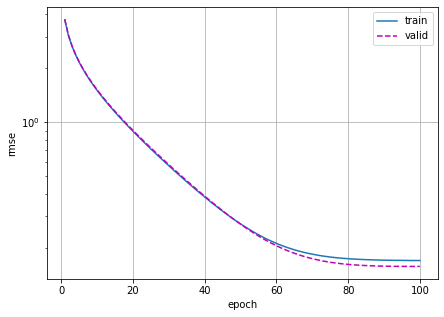

fold 0, train rmse: 0.169550, valid rmse: 0.157191


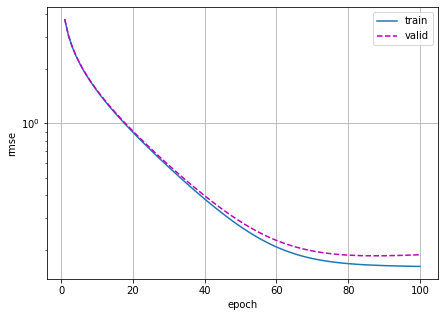

fold 1, train rmse: 0.162046, valid rmse: 0.188137


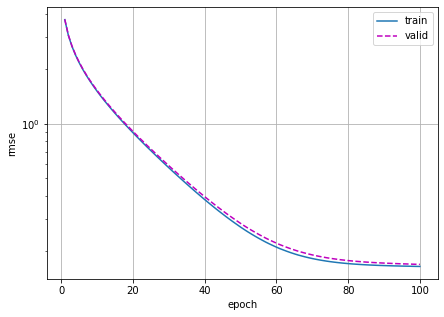

fold 2, train rmse: 0.163715, valid rmse: 0.168035


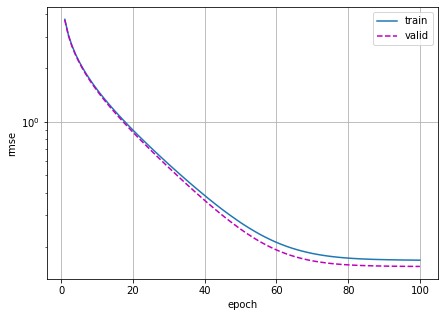

fold 3, train rmse: 0.167667, valid rmse: 0.154655


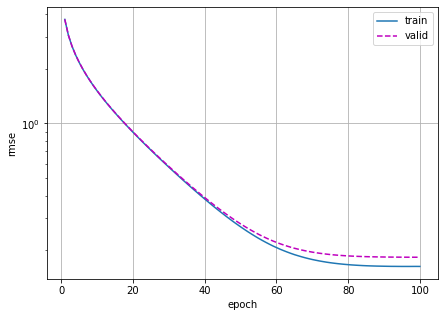

fold 4, train rmse: 0.162665, valid rmse: 0.182788
5-fold validation: avg train rmse: 0.165129, avg valid rmse: 0.170161


In [44]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print('%d-fold validation: avg train rmse: %f, avg valid rmse: %f' % (k, train_l, valid_l))

Notice that someimes the number of training errors for a set of hyperparameters can be very low, even as the number of errors on $k$-fold cross-validation is considerably higher. This indicates that we are overfitting. Throughout training you will want to monitor both numbers. No overfitting might indicate that our data can support a more powerful model. Massive overfitting might suggest that we can gain by incorporating regularization techniques.

### 4.10.8 Predict and Submit
Now that we know what a good choice of hyperparameters should be, we might as well use all the data to train on it (rather than just $1-1/k$ of the data that is used in the cross-validation slices). The model that we obtain in this way can then be applied to the test set. Saving the estimates in a CSV file will simplify uploading the results to Kaggle.

```python
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='rmse', yscale='log')
    print('train rmse %f' % train_ls[-1])
    # Apply the network to the test set
    preds = net(test_features).asnumpy()
    # Reformat it for export to Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)
```

One nice sanity check is to see whether the predictions on the test set resemble those of the k-fold cross-validation process. If they do, it is time to upload them to Kaggle. The following code will generate a file called submission.csv (CSV is one of the file formats accepted by Kaggle):

```python
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)
```

##### Summary
+ Real data often contains a mix of different data types and needs to be preprocessed.
+ Rescaling real-valued data to zero mean and unit variance is a good default. So is replacing missing values with their mean.
+ Transforming categorical variables into indicator variables allows us to treat them like vectors.
+ We can use k-fold cross validation to select the model and adjust the hyper-parameters.
+ Logarithms are useful for relative loss.

##### Exercises
1. Submit your predictions for this tutorial to Kaggle. How good are your predictions?
2. Can you improve your model by minimizing the log-price directly? What happens if you try to predict the log price rather than the price?
3. Is it always a good idea to replace missing values by their mean? Hint: can you construct a situation where the values are not missing at random?
4. Find a better representation to deal with missing values. Hint: what happens if you add an indicator variable?
5. Improve the score on Kaggle by tuning the hyperparameters through k-fold cross-validation.
6. Improve the score by improving the model (layers, regularization, dropout).
7. What happens if we do not standardize the continuous numerical features like we have done in this section?